In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
import requests
import json
from urllib.parse import urlencode
warnings.filterwarnings("ignore")

In [2]:
with open("C:/Users/Bora/Desktop/api.txt") as api:
    key=api.read()



In [3]:
import yfinance as yf 


In [453]:
params = {
    'series': "TP.DK.USD.S.YTL",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

usd = formatted_response['items']
usd = pd.DataFrame(usd)


usd = usd.drop(columns=['UNIXTIME','Tarih'])
usd.columns = ['USD/TL']
usd['USD/TL'] = pd.to_numeric(usd['USD/TL'])
usd=usd.set_index(pd.date_range(start="2006-01-01",freq="D",periods=len(usd)))
usd=usd.dropna()
usd

,USD/TL
2006-01-02,1.3483
2006-01-03,1.3506
2006-01-04,1.3484
2006-01-05,1.3381
2006-01-06,1.3362
...,...
2024-06-20,32.5164
2024-06-21,32.6298
2024-06-24,32.8400
2024-06-25,32.8669


In [5]:
params = {
    'series': "TP.FE.OKTG01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf = formatted_response['items']
enf = pd.DataFrame(enf)


enf = enf.drop(columns=['UNIXTIME','Tarih'])
enf.columns = ['TÜFE']
enf['TÜFE'] = pd.to_numeric(enf['TÜFE'])
enf=enf.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf)))
enf

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2024-01-31,1984.02
2024-02-29,2073.88
2024-03-31,2139.47
2024-04-30,2207.50


In [6]:
params = {
    'series': "TP.PR.ARZ13",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

money = formatted_response['items']
money = pd.DataFrame(money)


money = money.drop(columns=['UNIXTIME','Tarih'])
money.columns = ['Para Arzi']
money['Para Arzi'] = pd.to_numeric(money['Para Arzi'])
money=money.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(money)))
money=money.pct_change()*100
money=money.dropna()
money

,Para Arzi
2006-02-28,2.121748
2006-03-31,2.927613
2006-04-30,1.084694
2006-05-31,9.121170
2006-06-30,1.433197
...,...
2024-02-29,1.467195
2024-03-31,2.396667
2024-04-30,1.982216
2024-05-31,1.859475


In [7]:
params = {
    'series': "TP.PR.ARZ22",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m3 = formatted_response['items']
m3 = pd.DataFrame(m3)


m3 = m3.drop(columns=['UNIXTIME','YEARWEEK'])
m3.columns = ['Tarih','M3']
m3['M3'] = pd.to_numeric(m3['M3'])
m3 = m3.set_index(pd.to_datetime(m3["Tarih"], format="%d-%m-%Y"))
del m3["Tarih"]
m3=m3.pct_change(4)*100
m3=m3.resample('M').last()
m3=m3.dropna()
m3

,M3
Tarih,
2006-02-28,2.204708
2006-03-31,2.711175
2006-04-30,1.323922
2006-05-31,9.308200
2006-06-30,-0.288618
...,...
2024-02-29,2.359600
2024-03-31,2.687835
2024-04-30,2.405048


In [8]:
params = {
    'series': "TP.TIG08",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

issizlik = formatted_response['items']
issizlik = pd.DataFrame(issizlik)


issizlik = issizlik.drop(columns=['UNIXTIME','Tarih'])
issizlik.columns = ['İşsizlik']
issizlik['İşsizlik'] = pd.to_numeric(issizlik['İşsizlik'])
issizlik=issizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(issizlik)))
issizlik=issizlik.dropna()
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-12-31,8.8
2024-01-31,9.0
2024-02-29,8.7
2024-03-31,8.6


In [9]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2024-02-29,81.623999
2024-03-31,84.665499
2024-04-30,88.999999


In [10]:
params = {
    'series': "TP.KREDI.L001",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

kredi = formatted_response['items']
kredi = pd.DataFrame(kredi)


kredi = kredi.drop(columns=['UNIXTIME','YEARWEEK'])
kredi.columns = ['Tarih','Kredi']
kredi['Kredi'] = pd.to_numeric(kredi['Kredi'])
kredi = kredi.set_index(pd.to_datetime(kredi["Tarih"], format="%d-%m-%Y"))
del kredi["Tarih"]
kredi=kredi.pct_change(4)*100
kredi=kredi.resample('M').last()
kredi=kredi.dropna()
kredi

,Kredi
Tarih,
2006-02-28,1.559036
2006-03-31,5.768193
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.965727
...,...
2024-02-29,3.130261
2024-03-31,4.108658
2024-04-30,1.832087


In [11]:
params = {
    'series': "TP.APIFON4",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

pfaiz = formatted_response['items']
pfaiz = pd.DataFrame(pfaiz)


pfaiz = pfaiz.drop(columns=['UNIXTIME','Tarih'])
pfaiz.columns = ['Faiz']
pfaiz['Faiz'] = pd.to_numeric(pfaiz['Faiz'])
pfaiz=pfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(pfaiz)))
pfaiz=pfaiz.dropna()
pfaiz

,Faiz
2011-01-31,6.438571
2011-02-28,6.250000
2011-03-31,6.250000
2011-04-30,6.267619
2011-05-31,6.250000
...,...
2024-02-29,45.239524
2024-03-31,47.287619
2024-04-30,51.357222
2024-05-31,50.544545


In [12]:
motorin=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar (3).xls")
motorin=motorin.iloc[-1,:]
motorin=pd.DataFrame(motorin[3:])
motorin=motorin.set_index(pd.date_range(start="2005-01-31",periods=len(motorin),freq="M"))
motorin.columns=["Motorin"]
motorin

,Motorin
2005-01-31,1.75
2005-02-28,1.78
2005-03-31,1.87
2005-04-30,1.94
2005-05-31,1.88
...,...
2024-01-31,39.7935
2024-02-29,43.0968
2024-03-31,42.0568
2024-04-30,42.6763


In [13]:
params = {
    'series': "TP.TRY.MT02",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

mfaiz = formatted_response['items']
mfaiz = pd.DataFrame(mfaiz)


mfaiz = mfaiz.drop(columns=['UNIXTIME','Tarih'])
mfaiz.columns = ['Mevduat Faizi']
mfaiz['Mevduat Faizi'] = pd.to_numeric(mfaiz['Mevduat Faizi'])
mfaiz=mfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(mfaiz)))
mfaiz=mfaiz.dropna()
mfaiz

,Mevduat Faizi
2006-01-31,15.913333
2006-02-28,15.760000
2006-03-31,15.330000
2006-04-30,15.175000
2006-05-31,14.925000
...,...
2024-02-29,51.460000
2024-03-31,57.272000
2024-04-30,67.567500
2024-05-31,64.538000


In [14]:
params = {
    'series': "TP.BEK.S01.A.S",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf_belirsizlik = formatted_response['items']
enf_belirsizlik = pd.DataFrame(enf_belirsizlik)


enf_belirsizlik = enf_belirsizlik.drop(columns=['UNIXTIME','Tarih'])
enf_belirsizlik.columns = ['Enflasyon Belirsizliği']
enf_belirsizlik['Enflasyon Belirsizliği'] = pd.to_numeric(enf_belirsizlik['Enflasyon Belirsizliği'])
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf_belirsizlik)))
enf_belirsizlik=enf_belirsizlik.dropna()
enf_belirsizlik

,Enflasyon Belirsizliği
2013-01-31,0.32
2013-02-28,0.22
2013-03-31,0.16
2013-04-30,0.26
2013-05-31,0.29
...,...
2024-02-29,0.94
2024-03-31,0.64
2024-04-30,0.55
2024-05-31,0.47


In [15]:
params = {
    'series': "TP.FG.B01.95",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ito = formatted_response['items']
ito = pd.DataFrame(ito)


ito = ito.drop(columns=['UNIXTIME','Tarih'])
ito.columns = ['İTO']
ito['İTO'] = pd.to_numeric(ito['İTO'])
ito=ito.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ito)))
ito=ito.pct_change()*100
ito=ito.dropna()
ito

,İTO
2006-02-28,1.005528
2006-03-31,0.137253
2006-04-30,2.088936
2006-05-31,1.595826
2006-06-30,-0.100368
...,...
2024-01-31,6.717124
2024-02-29,4.070637
2024-03-31,3.926249
2024-04-30,4.894259


In [16]:
params = {
    'series': "TP.FE.OKTG04",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

tufec = formatted_response['items']
tufec = pd.DataFrame(tufec)


tufec = tufec.drop(columns=['UNIXTIME','Tarih'])
tufec.columns = ['TÜFE C']
tufec['TÜFE C'] = pd.to_numeric(tufec['TÜFE C'])
tufec=tufec.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(tufec)))
tufec=tufec.pct_change()*100
tufec=tufec.shift(1)
tufec=tufec.dropna()
tufec

,TÜFE C
2006-03-31,-1.101304
2006-04-30,-0.368460
2006-05-31,1.857331
2006-06-30,2.622237
2006-07-31,1.344445
...,...
2024-01-31,2.305439
2024-02-29,7.576163
2024-03-31,3.571725
2024-04-30,3.524351


In [17]:
params = {
    'series': "TP.TUFE1YI.T1",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

üfe = formatted_response['items']
üfe = pd.DataFrame(üfe)


üfe = üfe.drop(columns=['UNIXTIME','Tarih'])
üfe.columns = ['ÜFE']
üfe['ÜFE'] = pd.to_numeric(üfe['ÜFE'])
üfe=üfe.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(üfe)))
üfe=üfe.pct_change()*100
üfe=üfe.dropna()
üfe

,ÜFE
2006-02-28,0.256616
2006-03-31,0.247960
2006-04-30,1.938881
2006-05-31,2.770820
2006-06-30,4.021325
...,...
2024-01-31,4.136164
2024-02-29,3.737000
2024-03-31,3.294983
2024-04-30,3.602753


In [18]:
params = {
    'series': "TP.IHRACATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ihracat = formatted_response['items']
ihracat = pd.DataFrame(ihracat)


ihracat = ihracat.drop(columns=['UNIXTIME','Tarih'])
ihracat.columns = ['ÜFE']
ihracat['ÜFE'] = pd.to_numeric(ihracat['ÜFE'])
ihracat=ihracat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ihracat)))
ihracat=ihracat.shift(1)
ihracat=ihracat.dropna()
ihracat=ihracat.pct_change()*100
ihracat

,ÜFE
2013-02-28,NaN
2013-03-31,7.272509
2013-04-30,6.926004
2013-05-31,-4.381315
2013-06-30,5.141469
...,...
2023-12-31,0.693838
2024-01-31,0.017009
2024-02-29,-13.018698
2024-03-31,5.575513


In [19]:
params = {
    'series': "TP.ITHALATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ithalat = formatted_response['items']
ithalat = pd.DataFrame(ithalat)


ithalat = ithalat.drop(columns=['UNIXTIME','Tarih'])
ithalat.columns = ['ÜFE']
ithalat['ÜFE'] = pd.to_numeric(ithalat['ÜFE'])
ithalat=ithalat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ithalat)))
ithalat=ithalat.shift(1)
ithalat=ithalat.dropna()
ithalat=ithalat.pct_change()*100
ithalat

,ÜFE
2013-02-28,NaN
2013-03-31,3.993020
2013-04-30,4.802567
2013-05-31,11.093906
2013-06-30,0.635134
...,...
2023-12-31,-1.607103
2024-01-31,0.411271
2024-02-29,-9.758116
2024-03-31,6.304695


In [20]:
params = {
    'series': "TP.PKAUO.S01.A.U",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

anket = formatted_response['items']
anket = pd.DataFrame(anket)


anket = anket.drop(columns=['UNIXTIME','Tarih'])
anket.columns = ['ÜFE']
anket['ÜFE'] = pd.to_numeric(anket['ÜFE'])
anket=anket.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(anket)))
anket=anket.dropna()

anket

,ÜFE
2013-01-31,0.85
2013-02-28,0.53
2013-03-31,0.48
2013-04-30,0.65
2013-05-31,0.46
...,...
2024-02-29,3.80
2024-03-31,3.43
2024-04-30,3.25
2024-05-31,3.04


In [454]:
data=pd.DataFrame()
data["USD/TL"]=usd["USD/TL"].resample('M').mean().rolling(3).mean()
data["Motorin"]=motorin["Motorin"]
data["TÜFE"]=enf["TÜFE"]
data["TÜFEt-1"]=data["TÜFE"].shift(1)
data=data.pct_change()*100
data["M3"]=m3["M3"].shift(1)
data["ÜFEt1"]=üfe["ÜFE"].shift(1)
data["ÜFEt2"]=üfe["ÜFE"].shift(2)
data["TÜFECt1"]=tufec["TÜFE C"].shift(1)
data["TÜFECt2"]=tufec["TÜFE C"].shift(2)
data["İTO"]=ito["İTO"]
data["İhracat"]=ihracat["ÜFE"]
data["İthalat"]=ithalat["ÜFE"]
data["Anket"]=anket["ÜFE"]
data

,USD/TL,Motorin,TÜFE,TÜFEt-1,M3,ÜFEt1,ÜFEt2,TÜFECt1,TÜFECt2,İTO,İhracat,İthalat,Anket
2006-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-28,NaN,0.000000,0.218500,NaN,NaN,NaN,NaN,NaN,NaN,1.005528,NaN,NaN,NaN
2006-03-31,NaN,0.975610,0.274548,0.218500,2.204708,0.256616,NaN,NaN,NaN,0.137253,NaN,NaN,NaN
2006-04-30,0.075089,2.898551,1.336769,0.274548,2.711175,0.247960,0.256616,-1.101304,NaN,2.088936,NaN,NaN,NaN
2006-05-31,2.353679,4.694836,1.875397,1.336769,1.323922,1.938881,0.247960,-0.368460,-1.101304,1.595826,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,2.418218,8.301104,4.529188,6.703310,1.119951,4.136164,1.144328,2.305439,1.960293,4.070637,-13.018698,-9.758116,3.80
2024-03-31,3.239458,-2.413172,3.162671,4.529188,2.359600,3.737000,4.136164,7.576163,2.305439,3.926249,5.575513,6.304695,3.43
2024-04-30,2.452282,1.473008,3.179759,3.162671,2.687835,3.294983,3.737000,3.571725,7.576163,4.894259,7.050664,7.384867,3.25
2024-05-31,1.565526,-3.259186,3.368063,3.179759,2.405048,3.602753,3.294983,3.524351,3.571725,3.589407,NaN,NaN,3.04


In [455]:

data["Kredi"]=kredi["Kredi"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["İşsizlik"]=issizlik["İşsizlik"]
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Faiz"]
data["Zam"]=0
data=data[['USD/TL', 'Motorin','M3', 'Enflasyon Belirsizliği','Zam','TÜFEt-1','ParaArzi','Kredi','İhracat','İthalat','Mevduat Faizi','Anket','İşsizlik','Politika Faizi','ÜFEt2','TÜFECt2','ÜFEt1','TÜFECt1','İTO','TÜFE']]
data.iloc[:12,4]=380.46
data.iloc[12:18,4]=403.03
data.iloc[18:24,4]=419.15
data.iloc[24:30,4]=481.55
data.iloc[30:36,4]=503.26
data.iloc[36:42,4]=527.13
data.iloc[42:48,4]=546.48
data.iloc[48:54,4]=576.57
data.iloc[54:60,4]=599.12
data.iloc[60:66,4]=629.96
data.iloc[66:72,4]=658.95
data.iloc[72:78,4]=701.13
data.iloc[78:84,4]=739.79
data.iloc[84:90,4]=773.01
data.iloc[90:96,4]=803.68
data.iloc[96:102,4]=846.00
data.iloc[102:108,4]=891.03
data.iloc[108:114,4]=949.07
data.iloc[114:120,4]=1000.54
data.iloc[120:132,4]=1300.99
data.iloc[132:144,4]=1404.06
data.iloc[144:156,4]=1603.12
data.iloc[156:168,4]=2020.9
data.iloc[168:180,4]=2324.71
data.iloc[180:192,4]=2825.90
data.iloc[192:198,4]=4253.4
data.iloc[198:204,4]=5500.35
data.iloc[204:210,4]=8506.8
data.iloc[210:216,4]=11402.33
data.iloc[216:,4]=17002
data["Zam"]=data["Zam"].pct_change()*100
data=data.fillna(0)

data["İşsizlik"].iloc[-2:]=8.4


data=data.loc["2014-01-31":]
data["TÜFE"].loc["2023-05-31"]+=2.88
data["İhracat"].iloc[-2:]=[-14.64,25.04]
data["İthalat"].iloc[-2:]=[-2.65,5.07]
data["ÜFEt1"].iloc[-1]=1.96
data["ÜFEt2"].iloc[-1]=3.60
data["TÜFECt1"].iloc[-1]=3.76
data["Motorin"].iloc[-1]=-1.61
data["TÜFECt2"].iloc[-1]=3.5243
data=data.dropna()
data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Zam,TÜFEt-1,ParaArzi,Kredi,İhracat,İthalat,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,İTO,TÜFE
2014-01-31,3.732429,2.881984,3.413428,0.37,5.265777,0.460607,3.375162,2.886648,-7.844611,7.652883,9.0220,1.06,9.2,7.503636,0.618013,1.776282,1.106494,0.625859,0.333618,1.978080
2014-02-28,3.033477,1.685899,1.958423,0.31,0.000000,1.978080,1.804994,2.214819,-6.175956,-14.641565,10.6275,0.69,9.5,10.070500,1.106494,0.625859,3.319203,-0.111246,1.009554,0.428192
2014-03-31,2.465778,-2.278097,0.229599,0.16,0.000000,0.428192,0.451349,1.160171,4.991889,-6.505852,11.3125,0.65,9.5,10.200952,3.319203,-0.111246,1.383675,0.308798,0.989257,1.125608
2014-04-30,-1.344724,-6.214384,0.730196,0.23,0.000000,1.125608,0.796760,0.126575,12.575902,13.043316,11.0200,0.76,9.7,10.046190,1.383675,0.308798,0.736212,0.701489,2.649799,1.344970
2014-05-31,-1.859714,-0.561578,-0.093468,0.26,0.000000,1.344970,-0.362357,0.464970,-7.919312,0.662228,10.4940,0.63,9.7,9.891000,0.736212,0.701489,0.085477,1.197755,0.211698,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,2.418218,8.301104,1.119951,0.94,0.000000,6.703310,0.992308,2.597683,-13.018698,-9.758116,51.4600,3.80,8.7,45.239524,1.144328,1.960293,4.136164,2.305439,4.070637,4.529188
2024-03-31,3.239458,-2.413172,2.359600,0.64,0.000000,4.529188,1.467195,3.009414,5.575513,6.304695,57.2720,3.43,8.6,47.287619,4.136164,2.305439,3.737000,7.576163,3.926249,3.162671
2024-04-30,2.452282,1.473008,2.687835,0.55,0.000000,3.162671,2.396667,3.023668,7.050664,7.384867,67.5675,3.25,8.5,51.357222,3.737000,7.576163,3.294983,3.571725,4.894259,3.179759
2024-05-31,1.565526,-3.259186,2.405048,0.47,0.000000,3.179759,1.982216,2.979092,-14.640000,-2.650000,64.5380,3.04,8.4,50.544545,3.294983,3.571725,3.602753,3.524351,3.589407,3.368063


## Cari Ay Enflasyon Tahmini

In [27]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,Zam,ParaArzi,Kredi,Anket,İhracat,İşsizlik,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,TÜFE
0,0.436647,0.120222,0.254853,0.388678,0.647802,-0.357034,-0.695105,-1.224068,-0.544829,0.010796,-0.384633,-0.534925,0.039845
1,0.227287,-0.041395,-0.293182,-0.180780,0.188025,-0.632840,-0.567125,-1.025656,-0.380604,-0.529398,0.360123,-0.879837,-0.648162
2,0.057242,-0.577014,-0.293182,-0.671710,-0.533740,-0.662657,0.289409,-1.025656,0.363298,-0.875514,-0.291339,-0.683286,-0.338574
3,-1.084131,-1.108890,-0.293182,-0.546439,-1.241098,-0.580660,0.871076,-0.893381,-0.287417,-0.678278,-0.509263,-0.499535,-0.241197
4,-1.238388,-0.345076,-0.293182,-0.966819,-1.009512,-0.677565,-0.700834,-0.893381,-0.505091,-0.493885,-0.728288,-0.267318,-0.662797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.042997,0.852459,-0.293182,-0.475519,0.450044,1.685423,-1.091939,-1.554756,-0.367884,0.097201,0.635096,0.250999,1.172302
122,0.288986,-0.595266,-0.293182,-0.303290,0.731819,1.409617,0.334171,-1.620893,0.637956,0.259268,0.500745,2.717323,0.565694
123,0.053200,-0.070161,-0.293182,0.033804,0.741574,1.275441,0.447310,-1.687031,0.503759,2.734198,0.351971,0.843531,0.573280
124,-0.212413,-0.709580,-0.293182,-0.116506,0.711067,1.118902,-1.216287,-1.753168,0.355155,0.853867,0.455560,0.821363,0.656870


In [28]:
from sklearn.model_selection import train_test_split
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:-1,:]
y_train,y_test=y[:-7],y[-7:-1]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)


In [29]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
def weighted_mse(y_true, y_pred):
    n = len(y_true)
    weights = 1 / np.arange(1, n + 1)  # Ters orantılı ağırlıklar
    weights = weights[::-1]  # Ağırlıkları ters çevir (küçükten büyüğe)
    mse = np.sum(weights * (y_true - y_pred) ** 2) / n
    return mse
def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 256)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:-1])
    tahminler.loc["2024-01-31"]=6.70
    max=abs(tahminler["TÜFE"]-tahminler["Tahmin"]).max()
    mse=mean_squared_error(tahminler["TÜFE"],tahminler["Tahmin"])


    return mse # Return validation accuracy as the objective

In [ ]:
study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)

In [209]:
study.best_params

{'learning_rate': 0.009377039965970141,
 'units1': 43,
 'batch_size': 7,
 'activation1': 'tanh',
 'optimizer': 'adam',
 'rlrate': 0.2788740756825726}

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=43,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.2788740756825726)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.009377039965970141)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=7,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler.columns=["TÜFE"]
tahminler["NN1"]=scaler2.inverse_transform(y_pred)
tahminler=tahminler.set_index(data.index[-7:])

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.2090 - mean_squared_error: 1.0312 - val_loss: 1.9961 - val_mean_squared_error: 0.0949
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8213 - mean_squared_error: 0.3315 - val_loss: 0.8305 - val_mean_squared_error: 0.1964
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6785 - mean_squared_error: 0.1730 - val_loss: 0.3261 - val_mean_squared_error: 0.1008
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3526 - mean_squared_error: 0.1619 - val_loss: 0.2447 - val_mean_squared_error: 0.1136
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2830 - mean_squared_error: 0.1744 - val_loss: 0.2185 - val_mean_squared_error: 0.1161
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2836 - mean_squared_error: 0.1938 - val_loss: 0.1616 - val_mean_squared_error: 0.0924
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2125 - mean_squared_error: 0.1475 - val_loss: 0.1

In [33]:
mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["NN1"].iloc[:-1])

0.17387709997486422

In [34]:
tahminler

,TÜFE,NN1
2023-12-31,2.927207,3.010675
2024-01-31,6.703310,6.830270
2024-02-29,4.529188,3.978037
2024-03-31,3.162671,2.966294
2024-04-30,3.179759,3.534941
2024-05-31,3.368063,2.625304
2024-06-30,0.000000,2.244194


In [35]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-13,:],X.iloc[-13:,:]
y_train,y_test=y[:-13],y[-13:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=32,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.17424279013407418)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.014212504541816193)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=7,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler2=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler2.columns=["TÜFE"]
tahminler2["NN2"]=scaler2.inverse_transform(y_pred)
tahminler2=tahminler2.set_index(data.index[-13:])


Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.6809 - mean_squared_error: 0.4261 - val_loss: 0.8563 - val_mean_squared_error: 0.1261
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8933 - mean_squared_error: 0.3305 - val_loss: 0.3200 - val_mean_squared_error: 0.0828
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3581 - mean_squared_error: 0.1504 - val_loss: 0.2228 - val_mean_squared_error: 0.1001
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2762 - mean_squared_error: 0.1680 - val_loss: 0.2346 - val_mean_squared_error: 0.1657
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [36]:
mean_squared_error(tahminler2["TÜFE"].iloc[:-1],tahminler2["NN2"].iloc[:-1])

0.30486609289824745

In [37]:
tahminler2

,TÜFE,NN2
2023-06-30,3.920498,3.525492
2023-07-31,9.488824,9.633574
2023-08-31,9.086793,8.158588
2023-09-30,4.753114,5.189009
2023-10-31,3.433981,4.189612
2023-11-30,3.281097,4.074047
2023-12-31,2.927207,3.340102
2024-01-31,6.703310,6.837417
2024-02-29,4.529188,4.260104
2024-03-31,3.162671,2.839868


In [38]:
features=['USD/TL', 'Motorin', 'TÜFEt-1', 'ParaArzi', 'Kredi', 'Anket', 
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-25,:],X.iloc[-13:,:]
y_train,y_test=y[:-25],y[-13:]
X_val=X.iloc[-25:-13,:]
y_val=y[-25:-13]
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=29,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.42170876820347847)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0017583324241828712)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=25,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler3=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler3.columns=["TÜFE"]
tahminler3["NN3"]=scaler2.inverse_transform(y_pred)
tahminler3=tahminler3.set_index(data.index[-13:])


Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 7.6487 - mean_squared_error: 1.1507 - val_loss: 7.9499 - val_mean_squared_error: 1.7150
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.0323 - mean_squared_error: 0.8633 - val_loss: 7.4430 - val_mean_squared_error: 1.5303
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5296 - mean_squared_error: 0.6818 - val_loss: 6.9688 - val_mean_squared_error: 1.3743
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0866 - mean_squared_error: 0.5557 - val_loss: 6.5199 - val_mean_squared_error: 1.2371
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6835 - mean_squared_error: 0.4626 - val_loss: 6.0961 - val_mean_squared_error: 1.1163
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3129 - mean_squared_error: 0.3929 - val_loss: 5.6990 - val_mean_squared_error: 1.0120
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9710 - mean_squared_error: 0.3416 - val_loss: 5.3290 - va

In [ ]:
tahminler2

In [39]:
tahminler3

,TÜFE,NN3
2023-06-30,3.920498,2.896381
2023-07-31,9.488824,8.638944
2023-08-31,9.086793,7.983024
2023-09-30,4.753114,5.238057
2023-10-31,3.433981,4.106438
2023-11-30,3.281097,3.892936
2023-12-31,2.927207,3.142150
2024-01-31,6.703310,4.899003
2024-02-29,4.529188,3.818145
2024-03-31,3.162671,2.840027


In [42]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-14,:],X.iloc[-14:,:]
y_train,y_test=y[:-14],y[-14:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=26,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.1640998114336349)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.021385011088592594)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=5000, batch_size=33,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler4=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler4.columns=["TÜFE"]
tahminler4["NN4"]=scaler2.inverse_transform(y_pred)
tahminler4=tahminler4.set_index(data.index[-14:])

Epoch 1/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 3.4518 - mean_squared_error: 1.0343 - val_loss: 2.8121 - val_mean_squared_error: 0.8585
Epoch 2/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1432 - mean_squared_error: 1.2838 - val_loss: 1.6284 - val_mean_squared_error: 0.1546
Epoch 3/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7121 - mean_squared_error: 0.3080 - val_loss: 1.5360 - val_mean_squared_error: 0.4270
Epoch 4/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5084 - mean_squared_error: 0.4516 - val_loss: 0.8772 - val_mean_squared_error: 0.0307
Epoch 5/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9722 - mean_squared_error: 0.1621 - val_loss: 0.7961 - val_mean_squared_error: 0.1405
Epoch 6/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8607 - mean_squared_error: 0.2350 - val_loss: 0.5511 - val_mean_squared_error: 0.0559
Epoch 7/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6146 - mean_squared_error: 0.1433 - val_loss: 0.4249 - va

In [43]:
tahminler4

,TÜFE,NN4
2023-05-31,2.923076,1.677841
2023-06-30,3.920498,3.662138
2023-07-31,9.488824,9.353954
2023-08-31,9.086793,8.180726
2023-09-30,4.753114,5.429341
2023-10-31,3.433981,4.397718
2023-11-30,3.281097,4.088316
2023-12-31,2.927207,3.358811
2024-01-31,6.703310,6.937675
2024-02-29,4.529188,4.380619


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


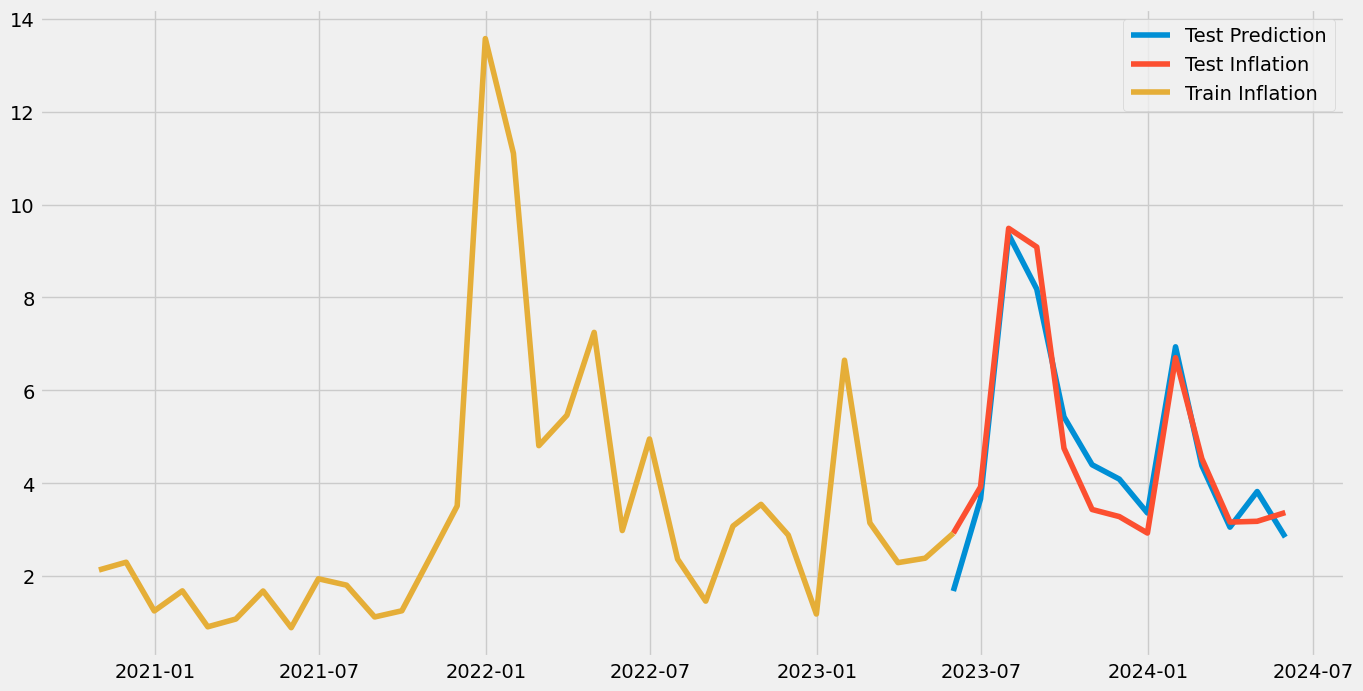

In [44]:
plt.figure(figsize=(15,8))
plt.plot(pd.DataFrame(scaler2.inverse_transform(np.array(model.predict(scaled_data.iloc[-14:-1,:-1])).reshape(-1,1))).set_index(data1.index[-14:-1]),label="Test Prediction")
plt.plot(data["TÜFE"].iloc[-14:-1],label="Test Inflation")
plt.plot(data["TÜFE"].iloc[-45:-13],label="Train Inflation")

plt.legend()

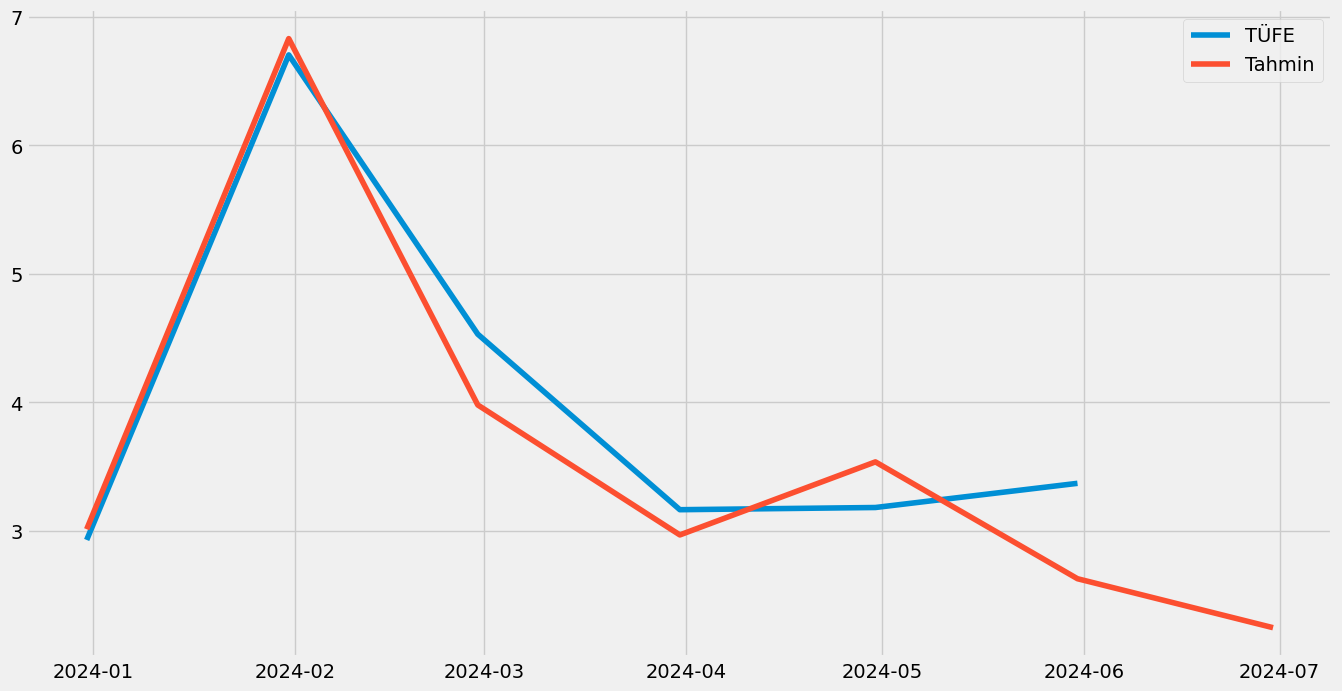

In [45]:
plt.figure(figsize=(15,8))
plt.plot(tahminler["TÜFE"].iloc[:-1],label="TÜFE")
plt.plot(tahminler["NN1"],label="Tahmin")
plt.legend()

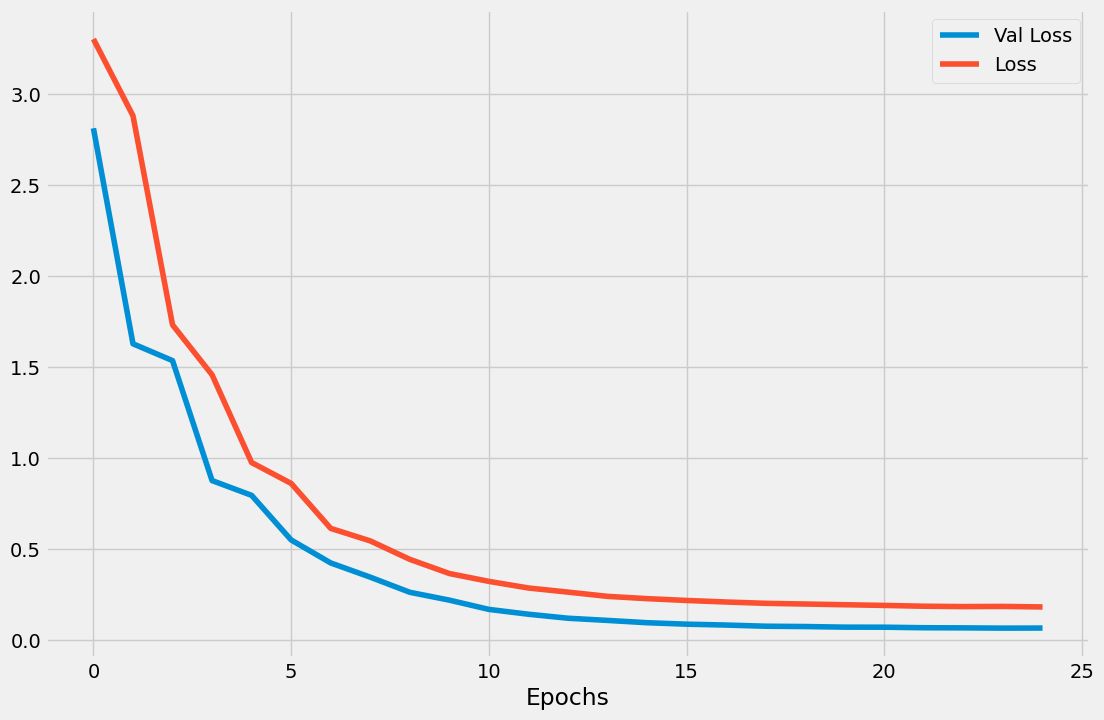

In [46]:
plt.figure(figsize=(12,8))
plt.plot(history.history["val_loss"],label="Val Loss")
plt.plot(history.history["loss"],label="Loss")
plt.xlabel("Epochs")
plt.legend()

In [47]:
kısatahminler=pd.concat([tahminler.iloc[-7:],tahminler2.iloc[-7:,1],tahminler3.iloc[-7:,1],tahminler4.iloc[-7:,1]],axis=1)
kısatahminler["Ortalama"]=kısatahminler.iloc[:,1:].mean(axis=1)
kısatahminler

,TÜFE,NN1,NN2,NN3,NN4,Ortalama
2023-12-31,2.927207,3.010675,3.340102,3.142150,3.358811,3.212935
2024-01-31,6.703310,6.830270,6.837417,4.899003,6.937675,6.376091
2024-02-29,4.529188,3.978037,4.260104,3.818145,4.380619,4.109226
2024-03-31,3.162671,2.966294,2.839868,2.840027,3.053555,2.924936
2024-04-30,3.179759,3.534941,3.996898,3.685938,3.820766,3.759636
2024-05-31,3.368063,2.625304,2.923874,2.778111,2.838772,2.791515
2024-06-30,0.000000,2.244194,2.116495,2.125612,2.082666,2.142242


## Orta Vadeli Tahminler

In [23]:
model=auto_arima(pfaiz["Faiz"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Faiz"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Faiz"]
row=pd.DataFrame({"Faiz":pfaiz.iloc[-4:,0]},index=pd.date_range(start="2024-03-30",periods=4,freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)

faiztahmin.iloc[4:,0]=[50,50,50,50,50,50,50,50,50,50,50,45,40,35,35,35,35,30,30,30,30,30,25,25,25]
faiztahmin

,Faiz
2024-03-31,47.287619
2024-04-30,51.357222
2024-05-31,50.544545
2024-06-30,50.029333
2024-07-31,50.000000
2024-08-31,50.000000
2024-09-30,50.000000
2024-10-31,50.000000
2024-11-30,50.000000
2024-12-31,50.000000


In [24]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [25]:
exog=pd.DataFrame()
exog["X"]=usd["USD/TL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2024-02-29,2481.908203
2024-03-31,2656.218779
2024-04-30,2862.071302
2024-05-31,2679.695793


In [26]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,25]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [27]:
faiztahmin.columns=["Faiz"]


In [28]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Faiz"].iloc[95:-13]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Faiz"].iloc[-14:-3],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [29]:
exog=pfaiz["Faiz"].iloc[36:-2]
exog=np.array(exog).reshape(-1,1)

In [30]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [31]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(27,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2024-05-31,8.452397
2024-06-30,8.443984
2024-07-31,8.435135
2024-08-31,8.421754
2024-09-30,8.418178
2024-10-31,8.416087
2024-11-30,8.413071
2024-12-31,8.412265
2025-01-31,8.411794
2025-02-28,8.411114


In [32]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [33]:
import optuna


In [464]:
import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.50,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=usd.index
    sn["y"]=usd.values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=500,freq="D")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(usd.values,predictions["yhat"][:-500])
    return mae_score
try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)
    print("Optimize işlemi başarıyla tamamlandı.")
except Exception as e:
    print(f'Hata oluştu: {e}')
    print('Optimize işlemi başarısız oldu. Devam ediyor...')


[I 2024-06-26 21:33:44,639] A new study created in memory with name: no-name-f46033ee-3275-4ae9-bc70-7f1a7fe870ad
21:33:44 - cmdstanpy - INFO - Chain [1] start processing
21:33:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-06-26 21:33:50,254] Trial 0 finished with value: 0.39922041225975674 and parameters: {'changepoint_prior_scale': 5.11378361038512, 'changepoint_range': 0.8308074815820483, 'growth': 'linear', 'seasonality_prior_scale': 6.224052535686876, 'n_changepoints': 86, 'yearly_seasonality': False, 'weekly_seasonality': False}. Best is trial 0 with value: 0.39922041225975674.
21:33:50 - cmdstanpy - INFO - Chain [1] start processing
21:33:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-06-26 21:34:01,415] Trial 1 finished with value: 0.25385607642413444 and parameters: {'changepoint_prior_scale': 6.723500412914715, 'changepoint_range': 0.8902819273083264, 'growth': 'linear', 'seasonality_prior_scale': 6.371210892364816, 'n_changepoints': 95, 'yearly_seasona

KeyboardInterrupt: 

In [465]:
study.best_params

{'changepoint_prior_scale': 3.01514200960066,
 'changepoint_range': 0.9857778668108779,
 'growth': 'linear',
 'seasonality_prior_scale': 2.1119329107633154,
 'n_changepoints': 82,
 'yearly_seasonality': True,
 'weekly_seasonality': 'auto'}

In [471]:
sn=pd.DataFrame()
sn["ds"]=usd.index
sn["y"]=usd.values
prophet=Prophet(growth="linear",changepoint_prior_scale=8.828175414699565,changepoint_range=0.9822080828826867,seasonality_prior_scale=7.816953755754968,n_changepoints=100,interval_width=0.70,yearly_seasonality=False,weekly_seasonality="auto")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=500,freq="D")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:04 - cmdstanpy - INFO - Chain [1] done processing


In [475]:
(predictions["yhat"].resample('M').mean().tail(18).pct_change()*100).dropna()

ds
2024-07-31    1.441780
2024-08-31    1.480562
2024-09-30    1.432282
2024-10-31    1.405846
2024-11-30    1.396896
2024-12-31    1.371006
2025-01-31    1.371787
2025-02-28    1.295075
2025-03-31    1.279387
2025-04-30    1.295355
2025-05-31    1.287684
2025-06-30    1.269633
2025-07-31    1.248201
2025-08-31    1.265022
2025-09-30    1.215588
2025-10-31    1.206141
2025-11-30    0.775453
Freq: ME, Name: yhat, dtype: float64

In [476]:
usdtahmin=(predictions["yhat"].resample('M').mean().tail(18).pct_change()*100).dropna()
usdtahmin

ds
2024-07-31    1.441780
2024-08-31    1.480562
2024-09-30    1.432282
2024-10-31    1.405846
2024-11-30    1.396896
2024-12-31    1.371006
2025-01-31    1.371787
2025-02-28    1.295075
2025-03-31    1.279387
2025-04-30    1.295355
2025-05-31    1.287684
2025-06-30    1.269633
2025-07-31    1.248201
2025-08-31    1.265022
2025-09-30    1.215588
2025-10-31    1.206141
2025-11-30    0.775453
Freq: ME, Name: yhat, dtype: float64

In [478]:
usd_aylık=usd.resample('M').mean().dropna()

In [479]:
usdtahmin1 = []
result = usd_aylık.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([usd_aylık["USD/TL"].loc["2024-03-31":],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2024-03-31", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2024-03-31,31.986743
2024-04-30,32.329467
2024-05-31,32.247882
2024-06-30,32.466453
2024-07-31,32.934548
2024-08-31,33.422164
2024-09-30,33.900864
2024-10-31,34.377458
2024-11-30,34.857675
2024-12-31,35.335576


In [39]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'growth':trial.suggest_categorical('growth',['linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[50:].index
    sn["y"]=df14[50:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[50:].index\n    sn["y"]=df14[50:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = optuna.create_study(direction=

In [40]:
"""study.best_params"""

'study.best_params'

In [41]:
sn=pd.DataFrame()
sn["ds"]=df14.index
sn["y"]=df14.values
prophet=Prophet(growth="linear",changepoint_prior_scale=9.333547662504625,changepoint_range=0.9362159367416,seasonality_prior_scale=2.378940289163559,n_changepoints=98)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

20:24:07 - cmdstanpy - INFO - Chain [1] start processing
20:24:08 - cmdstanpy - INFO - Chain [1] done processing


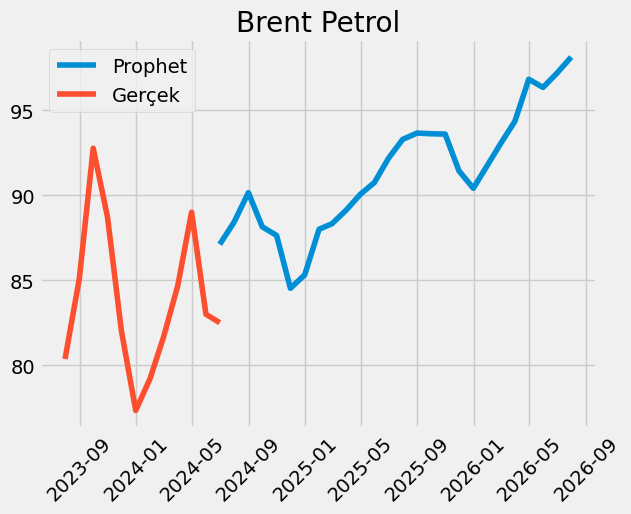

In [42]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-26:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [43]:
brenttahmin=predictions["yhat"][-29:]
brenttahmin

ds
2024-03-31    83.948399
2024-04-30    83.264711
2024-05-31    85.130879
2024-06-30    87.108138
2024-07-31    88.414291
2024-08-31    90.151042
2024-09-30    88.139715
2024-10-31    87.632165
2024-11-30    84.518404
2024-12-31    85.314022
2025-01-31    87.995726
2025-02-28    88.320787
2025-03-31    89.129388
2025-04-30    90.042979
2025-05-31    90.753225
2025-06-30    92.159951
2025-07-31    93.287643
2025-08-31    93.658065
2025-09-30    93.619197
2025-10-31    93.598892
2025-11-30    91.432065
2025-12-31    90.408387
2026-01-31    91.785997
2026-02-28    93.033438
2026-03-31    94.351360
2026-04-30    96.828550
2026-05-31    96.347148
2026-06-30    97.184222
2026-07-31    98.135950
Name: yhat, dtype: float64

In [44]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'growth':trial.suggest_categorical('growth',['linear'])

            

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n\n            \n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = o

20:24:08 - cmdstanpy - INFO - Chain [1] start processing
20:24:08 - cmdstanpy - INFO - Chain [1] done processing


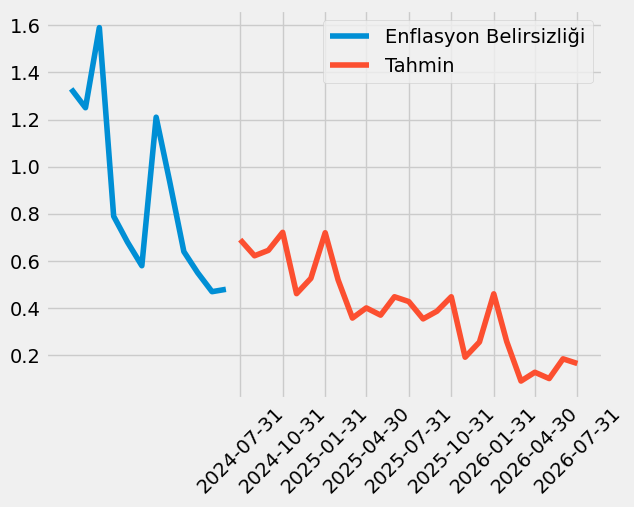

In [45]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
prophet=Prophet(changepoint_prior_scale=1.7,changepoint_range=0.91,seasonality_prior_scale=0.1053403857042852,n_changepoints=44,growth="linear")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])
plt.plot(enf_belirsizlik[-12:],label="Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.xticks(predictions.index[-25::3],rotation=45)
plt.legend()

In [46]:
enfbelirsizliktahmin1=pd.DataFrame(predictions["yhat"][-26:])
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1.index.names=[""]
enfbelirsizliktahmin1.iloc[0,0]=enf_belirsizlik.iloc[-1,0]
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
,
2024-06-30,0.480000
2024-07-31,0.690676
2024-08-31,0.622271
2024-09-30,0.645261
2024-10-31,0.721728
2024-11-30,0.461565
2024-12-31,0.526547
2025-01-31,0.719879
2025-02-28,0.519855


In [47]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [48]:
#study.best_params

In [480]:
((usdtahmin1[2:-2].pct_change(periods=1)*100).dropna())

,USD/TL
2024-06-30,0.677786
2024-07-31,1.441780
2024-08-31,1.480562
2024-09-30,1.432282
2024-10-31,1.405846
2024-11-30,1.396896
2024-12-31,1.371006
2025-01-31,1.371787
2025-02-28,1.295075
2025-03-31,1.279387


In [481]:
brenttahmin1=(brenttahmin.pct_change()*100).dropna()
brenttahmin1

ds
2024-04-30   -0.814414
2024-05-31    2.241246
2024-06-30    2.322611
2024-07-31    1.499462
2024-08-31    1.964333
2024-09-30   -2.231063
2024-10-31   -0.575848
2024-11-30   -3.553217
2024-12-31    0.941355
2025-01-31    3.143333
2025-02-28    0.369405
2025-03-31    0.915527
2025-04-30    1.025017
2025-05-31    0.788785
2025-06-30    1.550057
2025-07-31    1.223625
2025-08-31    0.397074
2025-09-30   -0.041500
2025-10-31   -0.021689
2025-11-30   -2.315013
2025-12-31   -1.119605
2026-01-31    1.523763
2026-02-28    1.359075
2026-03-31    1.416611
2026-04-30    2.625494
2026-05-31   -0.497169
2026-06-30    0.868810
2026-07-31    0.979303
Name: yhat, dtype: float64

In [483]:
(usdtahmin1[1:-1].pct_change(periods=1)*100).dropna()

,USD/TL
2024-05-31,-0.252354
2024-06-30,0.677786
2024-07-31,1.441780
2024-08-31,1.480562
2024-09-30,1.432282
2024-10-31,1.405846
2024-11-30,1.396896
2024-12-31,1.371006
2025-01-31,1.371787
2025-02-28,1.295075


In [488]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[1:-1].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1[1:-9]).dropna())/100)).values.reshape(-1,1))
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2024-04-28",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2024-04-30,-3.259186
2024-05-31,3.016139
2024-06-30,2.962861
2024-07-31,3.473978
2024-08-31,-0.830736
2024-09-30,0.821902
2024-10-31,-2.205955
2024-11-30,2.325267
2024-12-31,4.558240
2025-01-31,1.669264


In [489]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_rang

In [212]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
prophet=Prophet(changepoint_prior_scale=0.7034897796889,changepoint_range=0.88529543315216538,growth='linear',seasonality_prior_scale=3.03031163229546,n_changepoints=15)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:07:26 - cmdstanpy - INFO - Chain [1] start processing
21:07:26 - cmdstanpy - INFO - Chain [1] done processing


In [213]:
paraarzitahmin=(predictions["yhat"]).tail(25)
paraarzitahmin

ds
2024-07-31    3.280316
2024-08-31    2.169711
2024-09-30    3.581726
2024-10-31    3.452102
2024-11-30    3.132784
2024-12-31    3.197305
2025-01-31    1.770190
2025-02-28    2.131656
2025-03-31    3.845444
2025-04-30    3.397052
2025-05-31    3.006464
2025-06-30    3.339391
2025-07-31    2.678558
2025-08-31    2.696024
2025-09-30    2.866815
2025-10-31    2.603700
2025-11-30    2.582359
2025-12-31    3.291639
2026-01-31    1.437428
2026-02-28    2.046714
2026-03-31    3.458585
2026-04-30    2.431584
2026-05-31    2.678649
2026-06-30    3.310831
2026-07-31    2.083285
Name: yhat, dtype: float64

In [214]:
paraarzitahmin1 = paraarzitahmin
paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-07-30", periods=len(paraarzitahmin), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-6:,0]},index=pd.date_range(start="2024-01-31",periods=6,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
np.cumprod(1+(paraarzitahmin1.loc["2024-01-31":"2024-12-31"])/100)

,Para Arzi
2024-01-31,1.009923
2024-02-29,1.024741
2024-03-31,1.049300
2024-04-30,1.070100
2024-05-31,1.089998
2024-06-30,1.112609
2024-07-31,1.149106
2024-08-31,1.174038
2024-09-30,1.216089
2024-10-31,1.258069


In [58]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [59]:
#study.best_params

In [60]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,5),
                'n_changepoints':trial.suggest_int('n_changepoints',1,200),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),


                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3.values,predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,5),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,200),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=

In [61]:
"""study.best_params"""

'study.best_params'

In [219]:
sn=pd.DataFrame()
sn["ds"]=kredi["Kredi"].index
sn["y"]=kredi["Kredi"].values
prophet=Prophet(changepoint_prior_scale=0.8099759561372614,changepoint_range=0.952589785485153,growth="linear",seasonality_prior_scale=3.534157847860739,n_changepoints=189,yearly_seasonality=True,weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:08:12 - cmdstanpy - INFO - Chain [1] start processing
21:08:12 - cmdstanpy - INFO - Chain [1] done processing


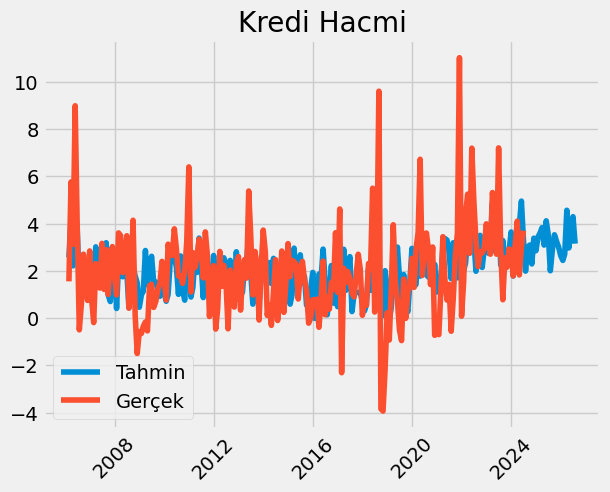

In [220]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(kredi["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [221]:
kreditahmin=(predictions["yhat"]).tail(25)
kreditahmin

ds
2024-07-31    1.993477
2024-08-31    2.989971
2024-09-30    3.096198
2024-10-31    2.296629
2024-11-30    3.386564
2024-12-31    2.855885
2025-01-31    3.444964
2025-02-28    3.593511
2025-03-31    3.832904
2025-04-30    3.094153
2025-05-31    4.123592
2025-06-30    3.543127
2025-07-31    2.008895
2025-08-31    2.921709
2025-09-30    3.532256
2025-10-31    3.248867
2025-11-30    3.010075
2025-12-31    2.650189
2026-01-31    2.445619
2026-02-28    2.715124
2026-03-31    4.569147
2026-04-30    2.974097
2026-05-31    3.826351
2026-06-30    4.298243
2026-07-31    3.155836
Name: yhat, dtype: float64

In [222]:
kreditahmin1 = kreditahmin

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-07-30", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":kredi.iloc[-4:,0]},index=pd.date_range(start="2024-03-30",periods=4,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2024-03-31,4.108658
2024-04-30,1.832087
2024-05-31,2.996531
2024-06-30,3.706120
2024-07-31,1.993477
2024-08-31,2.989971
2024-09-30,3.096198
2024-10-31,2.296629
2024-11-30,3.386564
2024-12-31,2.855885


In [66]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,150),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3"].index
    sn["y"]=m3["M3"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,150),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3"].index\n    sn["y"]=m3["M3"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["

In [67]:
sn=pd.DataFrame()
sn["ds"]=m3["M3"].index
sn["y"]=m3["M3"].values
prophet=Prophet(changepoint_prior_scale=2.5,changepoint_range=0.9,growth='linear',seasonality_prior_scale=4.7636997959024185,n_changepoints=10)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

20:24:15 - cmdstanpy - INFO - Chain [1] start processing
20:24:15 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
np.cumprod(1+(predictions["yhat"].tail(13))/100)

ds
2024-07-31    1.029619
2024-08-31    1.049387
2024-09-30    1.082219
2024-10-31    1.118134
2024-11-30    1.150628
2024-12-31    1.175112
2025-01-31    1.188393
2025-02-28    1.208186
2025-03-31    1.245517
2025-04-30    1.278454
2025-05-31    1.310736
2025-06-30    1.344164
2025-07-31    1.370886
Name: yhat, dtype: float64

In [69]:
m3tahmin=(predictions["yhat"].tail(13))


m3tahmin1 = np.array(m3tahmin).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-07-31", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-4:,0]},index=pd.date_range(start="2024-03-30",periods=4,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2024-03-31,2.687835
2024-04-30,2.405048
2024-05-31,3.532013
2024-06-30,3.061433
2024-07-31,2.961895
2024-08-31,1.919965
2024-09-30,3.128652
2024-10-31,3.318689
2024-11-30,2.906083
2024-12-31,2.127809


In [70]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [71]:
#study.best_params

In [72]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_int('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"].index
    sn["y"]=redkt["REDKT"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"],predictions["yhat"][:-36])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_int(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"].index\n    sn["y"]=redkt["REDKT"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scal

In [490]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean()],axis=1)

tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf["M3"]=m3tahmin1.shift(1)
tahmindf["Para Arzi"]=paraarzitahmin1.shift(1)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Kredi"]=kreditahmin1["Kredi"].rolling(3).mean()
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["Politika Faizi"]=faiztahmin["Faiz"]




tahmindf=tahmindf[['USD/TL', 'Motorin', 'Zam',
       'Enflasyon Belirsizliği', 'Para Arzi', 'M3', 'Kredi','İşsizlik','Politika Faizi']]

tahmindf.columns=["USD/TL","Motorin","Zam","Enflasyon Belirsizliği",'ParaArzi','M3', 'Kredi','İşsizlik','Politika Faizi']
tahmindf=tahmindf.dropna()


tahmindf=tahmindf.loc["2024-06-30":]
tahmindf["Motorin"].iloc[0]=-1.61
tahmindf

,USD/TL,Motorin,Zam,Enflasyon Belirsizliği,ParaArzi,M3,Kredi,İşsizlik,Politika Faizi
2024-06-30,0.496779,-1.610000,0.0,0.480000,1.859475,3.532013,2.844913,8.443984,50.029333
2024-07-31,0.623514,3.473978,0.0,0.690676,2.074382,3.061433,2.898709,8.435135,50.000000
2024-08-31,1.202556,-0.830736,0.0,0.622271,3.280316,2.961895,2.896523,8.421754,50.000000
2024-09-30,1.451492,0.821902,0.0,0.645261,2.169711,1.919965,2.693215,8.418178,50.000000
2024-10-31,1.439203,-2.205955,0.0,0.721728,3.581726,3.128652,2.794266,8.416087,50.000000
2024-11-30,1.411509,2.325267,0.0,0.461565,3.452102,3.318689,2.926464,8.413071,50.000000
2024-12-31,1.391088,4.558240,0.0,0.526547,3.132784,2.906083,2.846359,8.412265,50.000000
2025-01-31,1.379781,1.669264,30.0,0.719879,3.197305,2.127809,3.229138,8.411794,50.000000
2025-02-28,1.345610,2.206627,0.0,0.519855,1.770190,1.130217,3.298120,8.411114,50.000000
2025-03-31,1.315006,2.333649,0.0,0.358107,2.131656,1.665504,3.623793,8.410932,50.000000


In [492]:
data["TÜFE Lag"]=(enf.pct_change()*100).shift(1).dropna()["TÜFE"]
tahmindf["TÜFE Lag"]=0
tahmindf["TÜFE Lag"].iloc[0]=data["TÜFE"].iloc[-2]

In [493]:
data.loc["2023-06-30","TÜFE Lag"]=data.loc["2023-05-31","TÜFE"]

In [494]:
data=data.dropna()

In [497]:
data1=pd.concat([data,tahmindf],axis=0)
data1

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Zam,TÜFEt-1,ParaArzi,Kredi,İhracat,İthalat,...,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,İTO,TÜFE,TÜFE Lag
2014-01-31,3.732429,2.881984,3.413428,0.370000,5.265777,0.460607,3.375162,2.886648,-7.844611,7.652883,...,1.06,9.200000,7.503636,0.618013,1.776282,1.106494,0.625859,0.333618,1.978080,0.460607
2014-02-28,3.033477,1.685899,1.958423,0.310000,0.000000,1.978080,1.804994,2.214819,-6.175956,-14.641565,...,0.69,9.500000,10.070500,1.106494,0.625859,3.319203,-0.111246,1.009554,0.428192,1.978080
2014-03-31,2.465778,-2.278097,0.229599,0.160000,0.000000,0.428192,0.451349,1.160171,4.991889,-6.505852,...,0.65,9.500000,10.200952,3.319203,-0.111246,1.383675,0.308798,0.989257,1.125608,0.428192
2014-04-30,-1.344724,-6.214384,0.730196,0.230000,0.000000,1.125608,0.796760,0.126575,12.575902,13.043316,...,0.76,9.700000,10.046190,1.383675,0.308798,0.736212,0.701489,2.649799,1.344970,1.125608
2014-05-31,-1.859714,-0.561578,-0.093468,0.260000,0.000000,1.344970,-0.362357,0.464970,-7.919312,0.662228,...,0.63,9.700000,9.891000,0.736212,0.701489,0.085477,1.197755,0.211698,0.395224,1.344970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,1.315006,2.333649,1.665504,0.358107,0.000000,NaN,2.131656,3.623793,NaN,NaN,...,NaN,8.410932,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2025-04-30,1.289940,2.086626,3.089839,0.401186,0.000000,NaN,3.845444,3.506856,NaN,NaN,...,NaN,8.410826,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2025-05-31,1.287510,2.839370,2.644440,0.370479,0.000000,NaN,3.397052,3.683550,NaN,NaN,...,NaN,8.410672,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2025-06-30,1.284114,2.487099,2.525131,0.448415,0.000000,NaN,3.006464,3.586958,NaN,NaN,...,NaN,8.482949,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [498]:
features=['USD/TL','Motorin','M3','Enflasyon Belirsizliği', 'Kredi','İşsizlik','TÜFE']
data1=data1[features]


In [499]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
scaled_data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Kredi,İşsizlik,TÜFE
1,0.266473,-0.041903,-0.152495,-0.571827,0.109307,-0.801964,-0.654105
2,0.088606,-0.603302,-0.849646,-0.971324,-0.622493,-0.801964,-0.344878
3,-1.105267,-1.160777,-0.647780,-0.784892,-1.339686,-0.679165,-0.247614
4,-1.266620,-0.360201,-0.979923,-0.704993,-1.104881,-0.679165,-0.668723
5,-1.180803,0.108755,-1.145894,-0.545194,-0.662447,-0.679165,-0.706160
...,...,...,...,...,...,...,...
134,-0.271944,0.049834,-0.270615,-0.443703,1.086968,-1.470645,NaN
135,-0.279797,0.014850,0.303750,-0.328971,1.005827,-1.470710,NaN
136,-0.280559,0.121457,0.124142,-0.410752,1.128432,-1.470805,NaN
137,-0.281623,0.071567,0.076031,-0.203185,1.061409,-1.426427,NaN


In [500]:
from sklearn.model_selection import train_test_split
X=scaled_data
X=X.iloc[:-14,:-1]
y=scaled_data["TÜFE"][:-14]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-12,:],X.iloc[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)


In [81]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 128)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    rlrate2=trial.suggest_float('rlrate2',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate2)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)  

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))

    return mse  # Return validation accuracy as the objective


In [82]:
"""study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)"""

"study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective\nstudy.optimize(objective, n_trials=2000)  # You can adjust the number of trials\n\n# Print the best hyperparameters\nprint('Best hyperparameters:', study.best_params)"

In [501]:
from sklearn.model_selection import train_test_split
data1=pd.concat([data,tahmindf],axis=0)
features=['USD/TL','Motorin','M3','Enflasyon Belirsizliği', 'Kredi','İşsizlik','TÜFE']
data1=data1[features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
X=scaled_data
X=X.iloc[:-16,:-1]
y=scaled_data["TÜFE"][:-16]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)

In [502]:
import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout,SimpleRNN
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=3,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.11064517951376238)))
model.add(Dense(units=3,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.7726924049252087)))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.025721829128366083)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=3,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.3482 - mean_squared_error: 0.4531 - val_loss: 0.5919 - val_mean_squared_error: 0.1823
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5830 - mean_squared_error: 0.2632 - val_loss: 0.3931 - val_mean_squared_error: 0.1082
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4620 - mean_squared_error: 0.2002 - val_loss: 0.3568 - val_mean_squared_error: 0.1047
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4212 - mean_squared_error: 0.1869 - val_loss: 0.3605 - val_mean_squared_error: 0.0984


In [503]:
pred1=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [504]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


0.8017939956499999

In [505]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-14:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-06-30",periods=14,freq="1M"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


,TÜFE
2024-06-30,2.365491
2024-07-31,3.237759
2024-08-31,2.790251
2024-09-30,2.785746
2024-10-31,2.933257
2024-11-30,2.796396
2024-12-31,3.032102
2025-01-31,3.151565
2025-02-28,2.593238
2025-03-31,2.348032


In [506]:
tüfetahmin1 = []
result = enf["TÜFE"].iloc[-1]
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["NN"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2024-06-30", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin1

,NN
2024-06-30,2335.826965
2024-07-31,2411.455410
2024-08-31,2478.741075
2024-09-30,2547.792502
2024-10-31,2622.525794
2024-11-30,2695.862014
2024-12-31,2777.603303
2025-01-31,2865.141278
2025-02-28,2939.441207
2025-03-31,3008.460220


In [507]:
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
data1=pd.concat([data,tahmindf],axis=0)
features=['USD/TL','Motorin','M3', 'Kredi','İşsizlik','TÜFE Lag','TÜFE']
data1=data1[features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
X=scaled_data
X=X.iloc[:-16,:-1]
y=scaled_data["TÜFE"][:-16]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)
import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout,SimpleRNN
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=3,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.7756667258232616)))
model.add(Dense(units=113,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.22481422283704167)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.04592122323666263)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
model.fit(X_train, y_train, epochs=50, batch_size=60,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - loss: 16.8100 - mean_squared_error: 12.1616 - val_loss: 15.4498 - val_mean_squared_error: 11.7739
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 13.6295 - mean_squared_error: 9.9537 - val_loss: 5.0095 - val_mean_squared_error: 2.2026
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.3968 - mean_squared_error: 1.6489 - val_loss: 2.6018 - val_mean_squared_error: 0.2409
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.7175 - mean_squared_error: 0.4195 - val_loss: 2.1812 - val_mean_squared_error: 0.2201
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.3057 - mean_squared_error: 0.3984 - val_loss: 1.8357 - val_mean_squared_error: 0.2049
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.9711 - mean_squared_error: 0.3857 - val_loss: 1.5579 - val_mean_squared_error: 0.1959
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.7032 - mean_squared_error: 0.3801 - val_loss: 1.3319 - val_mean_s

In [508]:
mean_squared_error(scaler.inverse_transform(y_test).reshape(-1,1),scaler.inverse_transform(model.predict(X_test)).reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


0.6246766248599905

In [509]:
pred2=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [510]:
tahminler=pd.DataFrame(index=pd.date_range(start="2023-04-30",periods=12,freq="1M"))
tahminler["TÜFE"]=scaler.inverse_transform(y_test).reshape(-1,1)
tahminler["Tahmin"]=scaler.inverse_transform(model.predict(X_test)).reshape(-1,1)
tahminler

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


,TÜFE,Tahmin
2023-04-30,2.385509,3.395749
2023-05-31,2.923076,2.937317
2023-06-30,3.920498,4.540754
2023-07-31,9.488824,10.330500
2023-08-31,9.086793,8.416293
2023-09-30,4.753114,5.409303
2023-10-31,3.433981,3.369287
2023-11-30,3.281097,3.076110
2023-12-31,2.927207,2.753357
2024-01-31,6.703310,4.606319


In [511]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-14:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-06-30",periods=14,freq="1M"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


,TÜFE
2024-06-30,3.268320
2024-07-31,3.124805
2024-08-31,2.499061
2024-09-30,2.331036
2024-10-31,2.322150
2024-11-30,3.079072
2024-12-31,3.236120
2025-01-31,2.717580
2025-02-28,2.422573
2025-03-31,2.782846


In [512]:
tüfetahmin4 = []
result = enf["TÜFE"].iloc[-1]
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin4.append(result)

tüfetahmin4 = np.array(tüfetahmin4).reshape(-1, 1)
tüfetahmin4 = pd.DataFrame(tüfetahmin4)
tüfetahmin4.columns = ["NN"]
tüfetahmin4 = tüfetahmin4.set_index(pd.date_range(start="2024-06-30", periods=len(tüfetahmin4), freq="1M"))
tüfetahmin4

,NN
2024-06-30,2356.428167
2024-07-31,2430.061963
2024-08-31,2490.790696
2024-09-30,2548.851927
2024-10-31,2608.040097
2024-11-30,2688.343530
2024-12-31,2775.341565
2025-01-31,2850.763681
2025-02-28,2919.825522
2025-03-31,3001.079762


In [513]:
data1=pd.concat([data,tahmindf],axis=0)
features=['USD/TL','Motorin','M3', 'Kredi','TÜFE Lag','TÜFE']
data1=data1[features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
X=scaled_data
X=X.iloc[:-16,:-1]
y=scaled_data["TÜFE"][:-16]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)
import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout,SimpleRNN
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=48,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.7094881423211541)))
model.add(Dense(units=77,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.7574422111330262)))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.05310522650503496)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=58,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - loss: 55.0359 - mean_squared_error: 8.5724 - val_loss: 21.9101 - val_mean_squared_error: 0.9728
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 20.3410 - mean_squared_error: 1.4721 - val_loss: 11.5123 - val_mean_squared_error: 0.4764
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 11.5539 - mean_squared_error: 0.7013 - val_loss: 10.7158 - val_mean_squared_error: 0.1597
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 11.5183 - mean_squared_error: 0.8704 - val_loss: 11.3798 - val_mean_squared_error: 0.5836


In [514]:
pred3=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [515]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


0.8579892295377595

In [516]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-14:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-06-30",periods=14,freq="1M"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


,TÜFE
2024-06-30,2.535460
2024-07-31,1.882011
2024-08-31,1.398853
2024-09-30,1.379682
2024-10-31,1.315363
2024-11-30,1.958206
2024-12-31,2.155248
2025-01-31,1.550540
2025-02-28,1.352127
2025-03-31,1.513953


In [517]:
tüfetahmin3 = []
result = enf["TÜFE"].iloc[-1]
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin3.append(result)

tüfetahmin3 = np.array(tüfetahmin3).reshape(-1, 1)
tüfetahmin3 = pd.DataFrame(tüfetahmin3)
tüfetahmin3.columns = ["NN"]
tüfetahmin3 = tüfetahmin3.set_index(pd.date_range(start="2024-06-30", periods=len(tüfetahmin3), freq="1M"))
tüfetahmin3

,NN
2024-06-30,2339.705394
2024-07-31,2383.738914
2024-08-31,2417.083910
2024-09-30,2450.431972
2024-10-31,2482.664040
2024-11-30,2531.279714
2024-12-31,2585.835068
2025-01-31,2625.929480
2025-02-28,2661.435381
2025-03-31,2701.728270


In [518]:
data1=pd.concat([data,tahmindf],axis=0)
features=['USD/TL','Motorin','ParaArzi', 'Kredi','İşsizlik','TÜFE Lag','TÜFE']
data1=data1[features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
X=scaled_data
X=X.iloc[:-16,:-1]
y=scaled_data["TÜFE"][:-16]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=89,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.05688977475972332)))
model.add(Dense(units=18,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.6706865688008817)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.01985884761094969)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=57,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 25.2839 - mean_squared_error: 7.0684 - val_loss: 12.7737 - val_mean_squared_error: 2.3839
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 11.9360 - mean_squared_error: 2.4538 - val_loss: 6.0862 - val_mean_squared_error: 0.3047
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 5.7926 - mean_squared_error: 0.4103 - val_loss: 3.7481 - val_mean_squared_error: 0.1255
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.7455 - mean_squared_error: 0.3388 - val_loss: 2.5894 - val_mean_squared_error: 0.1392
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.6595 - mean_squared_error: 0.3496 - val_loss: 1.8912 - val_mean_squared_error: 0.1523
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.9960 - mean_squared_error: 0.3585 - val_loss: 1.4685 - val_mean_squared_error: 0.1758
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.5781 - mean_squared_error: 0.3670 - val_loss: 1.1655 

In [519]:
pred4=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [520]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


0.7648148521898391

In [521]:
tahminler=pd.DataFrame(index=pd.date_range(start="2023-04-30",periods=12,freq="1M"))
tahminler["TÜFE"]=scaler.inverse_transform(y_test)
tahminler["Tahmin"]=scaler.inverse_transform(model.predict(X_test))
tahminler.iloc[1,:]-=2.88
tahminler.iloc[-3,1]=6.83
tahminler

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,TÜFE,Tahmin
2023-04-30,2.385509,2.922876
2023-05-31,0.043076,-0.569757
2023-06-30,3.920498,4.033767
2023-07-31,9.488824,10.466438
2023-08-31,9.086793,9.104311
2023-09-30,4.753114,6.277113
2023-10-31,3.433981,3.459842
2023-11-30,3.281097,2.919497
2023-12-31,2.927207,2.431574
2024-01-31,6.703310,6.830000


In [522]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-14:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-06-30",periods=14,freq="1M"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


,TÜFE
2024-06-30,2.496746
2024-07-31,2.050492
2024-08-31,1.951393
2024-09-30,1.759688
2024-10-31,1.875297
2024-11-30,2.558442
2024-12-31,2.734754
2025-01-31,2.377195
2025-02-28,1.860283
2025-03-31,2.047095


In [523]:
tüfetahmin2= []
result = enf["TÜFE"].iloc[-1]
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["NN"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2024-06-30", periods=len(tüfetahmin2), freq="1M"))
tüfetahmin2

,NN
2024-06-30,2338.821995
2024-07-31,2386.779359
2024-08-31,2433.354805
2024-09-30,2476.174269
2024-10-31,2522.609884
2024-11-30,2587.149398
2024-12-31,2657.901578
2025-01-31,2721.085078
2025-02-28,2771.704955
2025-03-31,2828.444397


In [524]:
data1=pd.concat([data,tahmindf],axis=0)
features=['USD/TL','Motorin','ParaArzi', 'Kredi','İşsizlik','TÜFE Lag','TÜFE']
data1=data1[features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
X=scaled_data
X=X.iloc[:-16,:-1]
y=scaled_data["TÜFE"][:-16]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=15,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.1761578686433001)))
model.add(Dense(units=13,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.11029211327374655)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.02714594119301986)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=62,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 6.4389 - mean_squared_error: 3.3817 - val_loss: 2.6697 - val_mean_squared_error: 0.2150
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.7371 - mean_squared_error: 0.3621 - val_loss: 2.4998 - val_mean_squared_error: 0.5133
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.5479 - mean_squared_error: 0.6252 - val_loss: 1.8348 - val_mean_squared_error: 0.2016
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.9489 - mean_squared_error: 0.3623 - val_loss: 1.5238 - val_mean_squared_error: 0.1581
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.6465 - mean_squared_error: 0.3198 - val_loss: 1.3194 - val_mean_squared_error: 0.1661
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.4468 - mean_squared_error: 0.3281 - val_loss: 1.1582 - val_mean_squared_error: 0.1776
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.2923 - mean_squared_error: 0.3431 - val_loss: 1.0081 - v

In [525]:
pred5=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [526]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


0.7526276220927767

In [527]:
tahminler=pd.DataFrame(index=pd.date_range(start="2023-04-28",periods=12,freq="1M"))
tahminler["TÜFE"]=scaler.inverse_transform(y_test)
tahminler["Tahmin"]=scaler.inverse_transform(model.predict(X_test))
tahminler.iloc[1,:]-=2.88
tahminler.iloc[-3,1]=6.83
tahminler

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,TÜFE,Tahmin
2023-04-30,2.385509,3.155734
2023-05-31,0.043076,-0.408334
2023-06-30,3.920498,4.267818
2023-07-31,9.488824,10.405148
2023-08-31,9.086793,9.100255
2023-09-30,4.753114,6.324221
2023-10-31,3.433981,3.463035
2023-11-30,3.281097,3.029655
2023-12-31,2.927207,2.423877
2024-01-31,6.703310,6.830000


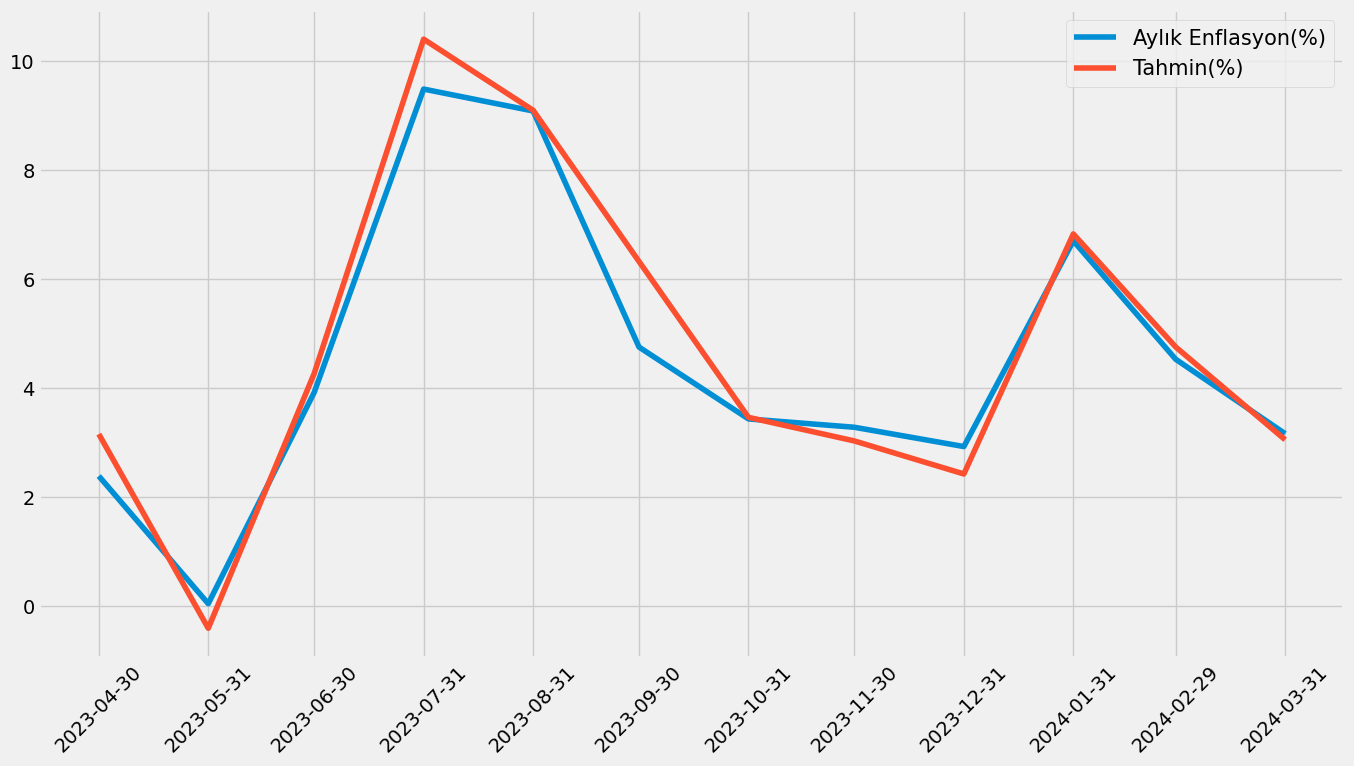

In [528]:
plt.figure(figsize=(15,8))
plt.plot(tahminler["TÜFE"],label="Aylık Enflasyon(%)")
plt.plot(tahminler["Tahmin"],label="Tahmin(%)")
plt.xticks(tahminler.index,rotation=45)
plt.legend(fontsize=15)
plt.show()

In [529]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-14:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-06-30",periods=14,freq="1M"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


,TÜFE
2024-06-30,2.317714
2024-07-31,1.741197
2024-08-31,1.733569
2024-09-30,1.516023
2024-10-31,1.687046
2024-11-30,2.496074
2024-12-31,2.697556
2025-01-31,2.308258
2025-02-28,1.648394
2025-03-31,1.947918


In [530]:
tüfetahmin00 = []
result = enf["TÜFE"].iloc[-1]
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin00.append(result)

tüfetahmin00 = np.array(tüfetahmin00).reshape(-1, 1)
tüfetahmin00 = pd.DataFrame(tüfetahmin00)
tüfetahmin00.columns = ["NN"]
tüfetahmin00 = tüfetahmin00.set_index(pd.date_range(start="2024-06-30", periods=len(tüfetahmin00), freq="1M"))
tüfetahmin00

,NN
2024-06-30,2334.736756
2024-07-31,2375.389122
2024-08-31,2416.568121
2024-09-30,2453.203859
2024-10-31,2494.590527
2024-11-30,2556.857345
2024-12-31,2625.830010
2025-01-31,2686.440943
2025-02-28,2730.724084
2025-03-31,2783.916351


In [531]:
data1=pd.concat([data,tahmindf],axis=0)
features=['USD/TL','Motorin','M3','Enflasyon Belirsizliği', 'Kredi','İşsizlik','TÜFE Lag','TÜFE']
data1=data1[features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
X=scaled_data
X=X.iloc[:-16,:-1]
y=scaled_data["TÜFE"][:-16]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=1,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.5704018348571585)))
model.add(Dense(units=38,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.5507354626876133)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.023834321386068204)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=57,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - loss: 3.0075 - mean_squared_error: 0.7261 - val_loss: 1.7325 - val_mean_squared_error: 0.2906
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.8978 - mean_squared_error: 0.5285 - val_loss: 1.3927 - val_mean_squared_error: 0.2615
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.7193 - mean_squared_error: 0.6572 - val_loss: 1.0461 - val_mean_squared_error: 0.1717
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.2935 - mean_squared_error: 0.4633 - val_loss: 0.8718 - val_mean_squared_error: 0.1486
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0991 - mean_squared_error: 0.4120 - val_loss: 0.7320 - val_mean_squared_error: 0.1183
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9589 - mean_squared_error: 0.3767 - val_loss: 0.6318 - val_mean_squared_error: 0.1014
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.8548 - mean_squared_error: 0.3528 - val_loss: 0.5572 - v

In [532]:
pred6=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [533]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


0.7330343959607318

In [534]:
tahminler=pd.DataFrame(index=pd.date_range(start="2023-04-28",periods=12,freq="1M"))
tahminler["TÜFE"]=scaler.inverse_transform(y_test)
tahminler["Tahmin"]=scaler.inverse_transform(model.predict(X_test))
tahminler.iloc[1,:]-=2.88
tahminler

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,TÜFE,Tahmin
2023-04-30,2.385509,2.717098
2023-05-31,0.043076,-0.455396
2023-06-30,3.920498,5.283607
2023-07-31,9.488824,9.839982
2023-08-31,9.086793,8.392426
2023-09-30,4.753114,6.481851
2023-10-31,3.433981,3.444819
2023-11-30,3.281097,3.013063
2023-12-31,2.927207,2.613524
2024-01-31,6.703310,5.027097


In [535]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-14:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-06-30",periods=14,freq="1M"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


,TÜFE
2024-06-30,2.577482
2024-07-31,2.985677
2024-08-31,2.441790
2024-09-30,2.427224
2024-10-31,2.678800
2024-11-30,2.498859
2024-12-31,2.804579
2025-01-31,2.853887
2025-02-28,2.032008
2025-03-31,1.779719


In [536]:
tüfetahmin000 = []
result = enf["TÜFE"].iloc[-1]
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin000.append(result)

tüfetahmin000 = np.array(tüfetahmin000).reshape(-1, 1)
tüfetahmin000 = pd.DataFrame(tüfetahmin000)
tüfetahmin000.columns = ["NN"]
tüfetahmin000 = tüfetahmin000.set_index(pd.date_range(start="2024-06-30", periods=len(tüfetahmin000), freq="1M"))
tüfetahmin000

,NN
2024-06-30,2340.664273
2024-07-31,2410.548959
2024-08-31,2469.409505
2024-09-30,2529.347609
2024-10-31,2597.103781
2024-11-30,2662.001747
2024-12-31,2736.659690
2025-01-31,2814.760874
2025-02-28,2871.957038
2025-03-31,2923.069806


In [537]:
oran=pd.Series([0.6,0.275,0.395,0.265,0.13,0.16])
oran=1/oran
oran.values

array([1.66666667, 3.63636364, 2.53164557, 3.77358491, 7.69230769,
       6.25      ])

In [538]:
tüfetahmin=pd.DataFrame()
tüfetahmin["NN1"]=tüfetahmin1["NN"]
tüfetahmin["NN2"]=tüfetahmin00["NN"]
tüfetahmin["NN3"]=tüfetahmin000["NN"]
tüfetahmin["NN4"]=tüfetahmin2["NN"]
tüfetahmin["NN5"]=tüfetahmin3["NN"]
tüfetahmin["NN6"]=tüfetahmin4["NN"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin["Ensemble"]=tüfetahmin["NN1"]*oran[0]+tüfetahmin["NN2"]*oran[1]+tüfetahmin["NN3"]*oran[2]+tüfetahmin["NN4"]*oran[3]+tüfetahmin["NN5"]*oran[4]+tüfetahmin["NN6"]*oran[5]
tüfetahmin["Ensemble"]=tüfetahmin["Ensemble"]/np.sum(oran)
tüfetahmin

,NN1,NN2,NN3,NN4,NN5,NN6,Ortalama,Ensemble
2024-06-30,2335.826965,2334.736756,2340.664273,2338.821995,2339.705394,2356.428167,2341.030592,2342.800412
2024-07-31,2411.455410,2375.389122,2410.548959,2386.779359,2383.738914,2430.061963,2399.662288,2398.795223
2024-08-31,2478.741075,2416.568121,2469.409505,2433.354805,2417.083910,2490.790696,2450.991352,2446.649719
2024-09-30,2547.792502,2453.203859,2529.347609,2476.174269,2450.431972,2548.851927,2500.967023,2492.873259
2024-10-31,2622.525794,2494.590527,2597.103781,2522.609884,2482.664040,2608.040097,2554.589020,2541.391979
2024-11-30,2695.862014,2556.857345,2662.001747,2587.149398,2531.279714,2688.343530,2620.248958,2605.279363
2024-12-31,2777.603303,2625.830010,2736.659690,2657.901578,2585.835068,2775.341565,2693.195202,2675.979797
2025-01-31,2865.141278,2686.440943,2814.760874,2721.085078,2625.929480,2850.763681,2760.686889,2737.906388
2025-02-28,2939.441207,2730.724084,2871.957038,2771.704955,2661.435381,2919.825522,2815.848031,2789.781573
2025-03-31,3008.460220,2783.916351,2923.069806,2828.444397,2701.728270,3001.079762,2874.449801,2847.304870


In [539]:
dates=pd.date_range('2006-02-28','2024-03-28' , freq='1M')
df=pd.DataFrame()

df["CPI"]=enf["TÜFE"]
df=df.set_index(pd.to_datetime(enf.index))




dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]



dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [540]:
row=pd.DataFrame(((tüfetahmin.iloc[0,:]/enf["TÜFE"].iloc[-1])-1)*100)
row=row.T
row


,NN1,NN2,NN3,NN4,NN5,NN6,Ortalama,Ensemble
2024-06-30,2.365491,2.317714,2.577482,2.496746,2.53546,3.26832,2.593536,2.671096


In [541]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin=pd.concat([row,aylıktahmin],axis=0)
aylıktahmin

,NN1,NN2,NN3,NN4,NN5,NN6,Ortalama,Ensemble
2024-06-30,2.365491,2.317714,2.577482,2.496746,2.535460,3.268320,2.593536,2.671096
2024-07-31,3.237759,1.741197,2.985677,2.050492,1.882011,3.124805,2.504525,2.390080
2024-08-31,2.790251,1.733569,2.441790,1.951393,1.398853,2.499061,2.139012,1.994939
2024-09-30,2.785746,1.516023,2.427224,1.759688,1.379682,2.331036,2.038998,1.889259
2024-10-31,2.933257,1.687046,2.678800,1.875297,1.315363,2.322150,2.144051,1.946297
2024-11-30,2.796396,2.496074,2.498859,2.558442,1.958206,3.079072,2.570274,2.513874
2024-12-31,3.032102,2.697556,2.804579,2.734754,2.155248,3.236120,2.783943,2.713737
2025-01-31,3.151565,2.308258,2.853887,2.377195,1.550540,2.717580,2.506008,2.314165
2025-02-28,2.593238,1.648394,2.032008,1.860283,1.352127,2.422573,1.998095,1.894703
2025-03-31,2.348032,1.947918,1.779719,2.047095,1.513953,2.782846,2.081141,2.061928


In [542]:
std=aylıktahmin.iloc[:,:-1].std(axis=1)
std

2024-06-30    0.315282
2024-07-31    0.623194
2024-08-31    0.481801
2024-09-30    0.513108
2024-10-31    0.563906
2024-11-30    0.340394
2024-12-31    0.334501
2025-01-31    0.508313
2025-02-28    0.426843
2025-03-31    0.407111
2025-04-30    0.417154
2025-05-31    0.434125
2025-06-30    0.407856
2025-07-31    0.379090
dtype: float64

In [543]:
aylıktahmin["Maksimum"]=aylıktahmin["Ensemble"]+std
aylıktahmin["Minimum"]=aylıktahmin["Ensemble"]-std
aylıktahmin

,NN1,NN2,NN3,NN4,NN5,NN6,Ortalama,Ensemble,Maksimum,Minimum
2024-06-30,2.365491,2.317714,2.577482,2.496746,2.535460,3.268320,2.593536,2.671096,2.986378,2.355815
2024-07-31,3.237759,1.741197,2.985677,2.050492,1.882011,3.124805,2.504525,2.390080,3.013274,1.766887
2024-08-31,2.790251,1.733569,2.441790,1.951393,1.398853,2.499061,2.139012,1.994939,2.476739,1.513138
2024-09-30,2.785746,1.516023,2.427224,1.759688,1.379682,2.331036,2.038998,1.889259,2.402367,1.376150
2024-10-31,2.933257,1.687046,2.678800,1.875297,1.315363,2.322150,2.144051,1.946297,2.510203,1.382392
2024-11-30,2.796396,2.496074,2.498859,2.558442,1.958206,3.079072,2.570274,2.513874,2.854268,2.173480
2024-12-31,3.032102,2.697556,2.804579,2.734754,2.155248,3.236120,2.783943,2.713737,3.048238,2.379236
2025-01-31,3.151565,2.308258,2.853887,2.377195,1.550540,2.717580,2.506008,2.314165,2.822479,1.805852
2025-02-28,2.593238,1.648394,2.032008,1.860283,1.352127,2.422573,1.998095,1.894703,2.321546,1.467859
2025-03-31,2.348032,1.947918,1.779719,2.047095,1.513953,2.782846,2.081141,2.061928,2.469040,1.654817


In [544]:
aylıktahmin[[ 'NN2','NN3','NN4','NN5','NN6', 'Ortalama','Ensemble']].to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/modelaylık.csv')

In [545]:
tüfe=df["CPI"].iloc[-1]

In [546]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin10),freq="1M"))
tüfetahmin10.columns=["CPI"]

tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [547]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin14 = []
lassotahmin=aylıktahmin["NN2"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin14),freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [548]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin15 = []
larstahmin=aylıktahmin["NN3"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin15),freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [549]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin16 = []
larstahmin=aylıktahmin["NN4"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin16),freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))


In [550]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin17 = []
larstahmin=aylıktahmin["NN5"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin17),freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [551]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin18 = []
larstahmin=aylıktahmin["NN6"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin18),freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))

In [552]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin19 = []
larstahmin=aylıktahmin["Ensemble"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin19.append(tüfe)
tüfetahmin19=pd.DataFrame(tüfetahmin19)
tüfetahmin19=tüfetahmin19.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin19),freq="1M"))
tüfetahmin19.columns=["CPI"]
tüfetahmin19=pd.concat([df["CPI"],tüfetahmin19["CPI"]],axis=0)
tüfetahmin19=pd.DataFrame((tüfetahmin19.pct_change(periods=12)*100).tail(38))

In [553]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin23 = []
maxtahmin=aylıktahmin["Maksimum"]
maxtahmin=1+(maxtahmin/100)
for elem in maxtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin23.append(tüfe)
tüfetahmin23=pd.DataFrame(tüfetahmin23)
tüfetahmin23=tüfetahmin23.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin23),freq="1M"))
tüfetahmin23.columns=["CPI"]
tüfetahmin23=pd.concat([df["CPI"],tüfetahmin23["CPI"]],axis=0)
tüfetahmin23=pd.DataFrame((tüfetahmin23.pct_change(periods=12)*100).tail(38))
tüfetahmin23


,CPI
2022-06-30,78.618397
2022-07-31,79.602053
2022-08-31,80.207594
2022-09-30,83.452494
2022-10-31,85.514786
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511


In [554]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin24 = []
mintahmin=aylıktahmin["Minimum"]
mintahmin=1+(mintahmin/100)
for elem in mintahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin24.append(tüfe)
tüfetahmin24=pd.DataFrame(tüfetahmin24)
tüfetahmin24=tüfetahmin24.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin24),freq="1M"))
tüfetahmin24.columns=["CPI"]
tüfetahmin24=pd.concat([df["CPI"],tüfetahmin24["CPI"]],axis=0)
tüfetahmin24=pd.DataFrame((tüfetahmin24.pct_change(periods=12)*100).tail(38))
tüfetahmin24

,CPI
2022-06-30,78.618397
2022-07-31,79.602053
2022-08-31,80.207594
2022-09-30,83.452494
2022-10-31,85.514786
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511


In [555]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)

In [556]:
aylık1=aylıktahmin
aylık1=aylık1[["Ensemble"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]],axis=0)
aylık1=pd.DataFrame(aylık1)
#aylık1=aylık1.set_index(pd.date_range(start="2014-01-30",end="2025-02-27",freq="1M"))
aylık1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

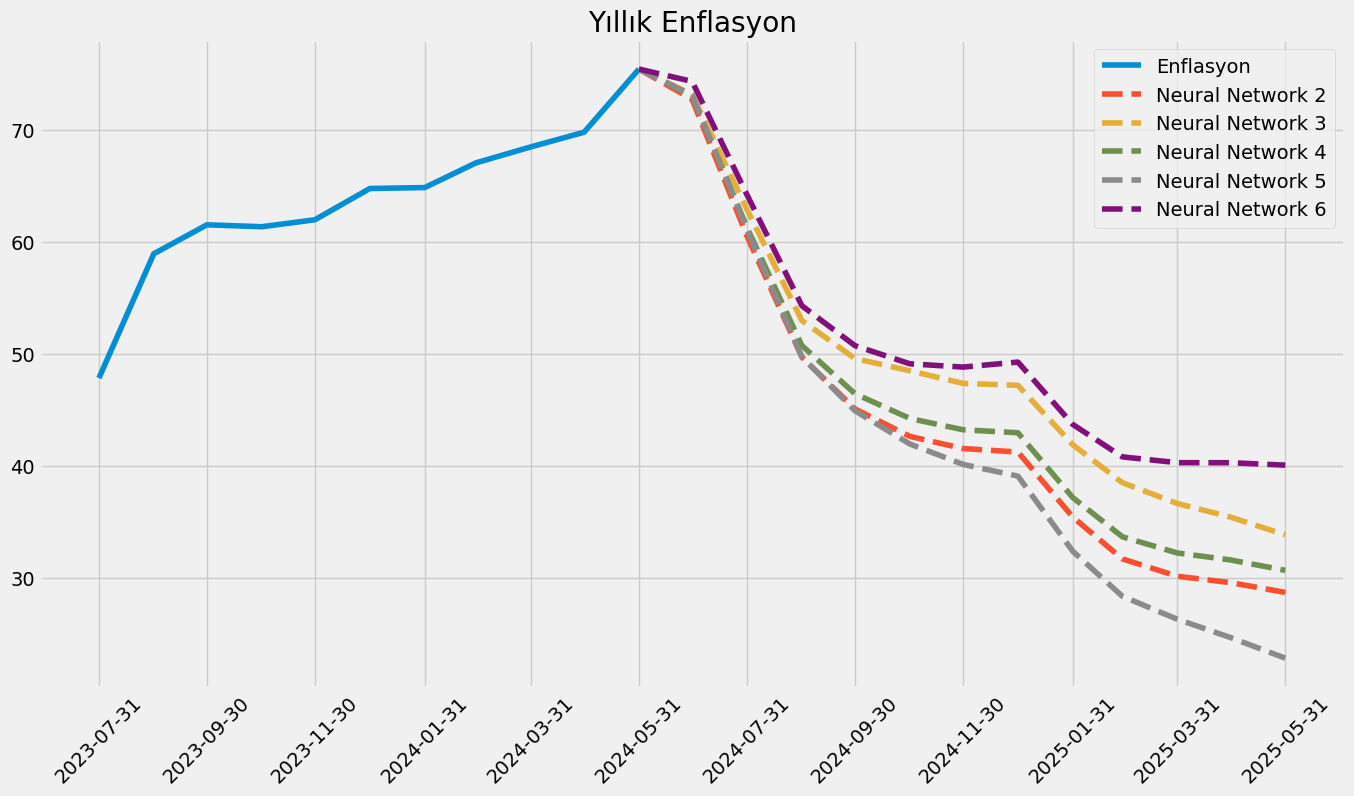

In [557]:
plt.style.use("fivethirtyeight")
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["NN2"]=tüfetahmin14["CPI"]
yıllıktahmin["NN3"]=tüfetahmin15["CPI"]
yıllıktahmin["NN4"]=tüfetahmin16["CPI"]
yıllıktahmin["NN5"]=tüfetahmin17["CPI"]
yıllıktahmin["NN6"]=tüfetahmin18["CPI"]
yıllıktahmin["Ensemble"]=tüfetahmin19["CPI"]
plt.figure(figsize=(15,8))
plt.plot(yıllıktahmin["Ortalama"].iloc[13:24],label="Enflasyon")
plt.plot(yıllıktahmin["NN2"].iloc[23:-2],'--',label="Neural Network 2")
plt.plot(yıllıktahmin["NN3"].iloc[23:-2],'--',label="Neural Network 3")
plt.plot(yıllıktahmin["NN4"].iloc[23:-2],'--',label="Neural Network 4")
plt.plot(yıllıktahmin["NN5"].iloc[23:-2],'--',label="Neural Network 5")
plt.plot(yıllıktahmin["NN6"].iloc[23:-2],'--',label="Neural Network 6")
plt.legend(loc=0)
plt.xticks(yıllıktahmin.index[13:-2:2],rotation=45)
#plt.xticks(pd.date_range(start="2022-12-30",end="2025-01-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [558]:
yıllıktahmin["Maksimum"]=tüfetahmin23["CPI"]
yıllıktahmin["Minimum"]=tüfetahmin24["CPI"]
yıllıktahmin

,Ortalama,NN2,NN3,NN4,NN5,NN6,Ensemble,Maksimum,Minimum
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494
2022-10-31,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786
2022-11-30,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260
2022-12-31,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597
2023-01-31,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481
2023-02-28,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828
2023-03-31,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511


In [559]:
yıllıktahmin1=yıllıktahmin[['Ortalama','NN2','NN3','NN4','NN5','NN6','Ensemble', 'Maksimum',
       'Minimum']]

yıllıktahmin1.columns=['Ortalama','NN2','NN3','NN4','NN5','NN6','Ensemble', 'Maksimum',
       'Minimum']
yıllıktahmin1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')

In [560]:
sonu2023=str(yıllıktahmin.iloc[20,0])[:5]
tepe=str(yıllıktahmin.iloc[-14,0])[:5]
sonu2024=str(yıllıktahmin.iloc[-7,0])[:5]
max=str(yıllıktahmin.iloc[-8,0])[:5]
min=str(yıllıktahmin.iloc[-8,0])[:5]


In [561]:
sonu12024=str(yıllıktahmin.iloc[-8,-3])[:5]

In [562]:
min1=str(yıllıktahmin.iloc[-8,-1])[:2]
max1=str(yıllıktahmin.iloc[-8,-2])[:2]

In [563]:
params = {
    'series': "TP.PKAUO.S01.D.U",
    'startDate': "01-06-2024",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ay12sonra = formatted_response['items']
ay12sonra = pd.DataFrame(ay12sonra)


ay12sonra = ay12sonra.drop(columns=['UNIXTIME','Tarih'])
ay12sonra.columns = ['Beklenti']
ay12sonra['Beklenti'] = pd.to_numeric(ay12sonra['Beklenti'])
ay12sonra=ay12sonra.set_index(pd.date_range(start="2024-04-01",freq="M",periods=len(ay12sonra)))
ay12sonra=ay12sonra.dropna()
ay12sonra

,Beklenti
2024-04-30,43.52


In [564]:
enf1=enf._append({"TÜFE":2207.50*1.0304},ignore_index=True)
enf1=enf.set_index(pd.date_range(start="2006-01-31",freq="M",periods=len(enf)))
enf1

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2024-01-31,1984.02
2024-02-29,2073.88
2024-03-31,2139.47
2024-04-30,2207.50


In [565]:
params = {
    'series': "TP.BEK.S01.A.A",
    'startDate': "30-09-2023",
    'endDate': "31-05-2024",
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

caritüfe = formatted_response['items']
caritüfe = pd.DataFrame(caritüfe)


caritüfe = caritüfe.drop(columns=['UNIXTIME','Tarih'])
caritüfe.columns = ['Beklenti']
caritüfe['Beklenti'] = pd.to_numeric(caritüfe['Beklenti'])
caritüfe["Beklenti"]=1+(caritüfe["Beklenti"]/100)
caritüfe=caritüfe.set_index(pd.date_range(start="2023-09-30",freq="M",periods=len(caritüfe)))
caritüfe["TÜFEt-1"]=enf["TÜFE"].shift(1).loc["2023-08-30":]
caritüfe["TÜFEt-12"]=enf["TÜFE"].loc["2022-09-30":"2023-05-31"].values
caritüfe["Tüfe Tahmin"]=caritüfe["Beklenti"]*caritüfe["TÜFEt-1"]
caritüfe["Enflasyon Tahmin"]=100*((caritüfe["Tüfe Tahmin"]/caritüfe["TÜFEt-12"])-1)
caritüfe

,Beklenti,TÜFEt-1,TÜFEt-12,Tüfe Tahmin,Enflasyon Tahmin
2023-09-30,1.0514,1614.31,1046.89,1697.285534,62.126444
2023-10-31,1.0430,1691.04,1084.00,1763.754720,62.708000
2023-11-30,1.0407,1749.11,1115.26,1820.298777,63.217436
2023-12-31,1.0329,1806.50,1128.45,1865.933850,65.353702
2024-01-31,1.0541,1859.38,1203.48,1959.972458,62.858748
2024-02-29,1.0389,1984.02,1241.33,2061.198378,66.047576
2024-03-31,1.0342,2073.88,1269.75,2144.806696,68.915668
2024-04-30,1.0330,2139.47,1300.04,2210.072510,70.000347
2024-05-31,1.0300,2207.50,1300.60,2273.725000,74.821236


In [566]:
geçmiş=pd.DataFrame({"Tahmin":[61.94,60.84,62.13,64.71,65.06,65.73,69.47,69.69,74.65]})
geçmiş=geçmiş.set_index(pd.date_range(start="2023-09-30",end="2024-05-31",freq="M"))
geçmiş

,Tahmin
2023-09-30,61.94
2023-10-31,60.84
2023-11-30,62.13
2023-12-31,64.71
2024-01-31,65.06
2024-02-29,65.73
2024-03-31,69.47
2024-04-30,69.69
2024-05-31,74.65


In [567]:
tüfe=enf1["TÜFE"].iloc[-1]
piyasa=[tüfe,1.0304,1.0256,1.0234]
piyasa=np.cumprod(piyasa)
piyasa=piyasa[1:]
piyasa

array([2351.21824   , 2411.40942694, 2467.83640753])

In [568]:
piyasa=pd.DataFrame({"TÜFE":[2274.608,2332.8379,2387.4263,np.nan,np.nan,np.nan,np.nan,2670.81]})
piyasa.columns=["TÜFE"]
piyasa=piyasa.set_index(pd.date_range(start="2024-05-31",end="2024-12-31",freq="M"))
piyasa

,TÜFE
2024-05-31,2274.6080
2024-06-30,2332.8379
2024-07-31,2387.4263
2024-08-31,NaN
2024-09-30,NaN
2024-10-31,NaN
2024-11-30,NaN
2024-12-31,2670.8100


In [569]:
enf[-7:]

,TÜFE
2023-11-30,1806.50
2023-12-31,1859.38
2024-01-31,1984.02
2024-02-29,2073.88
2024-03-31,2139.47
2024-04-30,2207.50
2024-05-31,2281.85


In [570]:
piyasa=pd.DataFrame({"TÜFE":[2274.608,2332.8379,2387.4263,np.nan,np.nan,np.nan,np.nan,2670.81,np.nan,np.nan,np.nan,np.nan,3039.65,np.nan]})
piyasa.columns=["TÜFE"]
piyasa=piyasa.set_index(pd.date_range(start="2024-05-31",end="2025-06-30",freq="M"))
piyasaenf=pd.concat([enf1["TÜFE"].iloc[:-1],piyasa["TÜFE"]],axis=0)
piyasaenf=pd.DataFrame(piyasaenf)
piyasaenf

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2025-02-28,NaN
2025-03-31,NaN
2025-04-30,NaN
2025-05-31,3039.65


In [571]:
piyasaenf.interpolate(method="linear", inplace=True)
piyasaenf.pct_change(12)*100

,TÜFE
2006-01-31,NaN
2006-02-28,NaN
2006-03-31,NaN
2006-04-30,NaN
2006-05-31,NaN
...,...
2025-02-28,35.897255
2025-03-31,35.178993
2025-04-30,34.354790
2025-05-31,33.634015


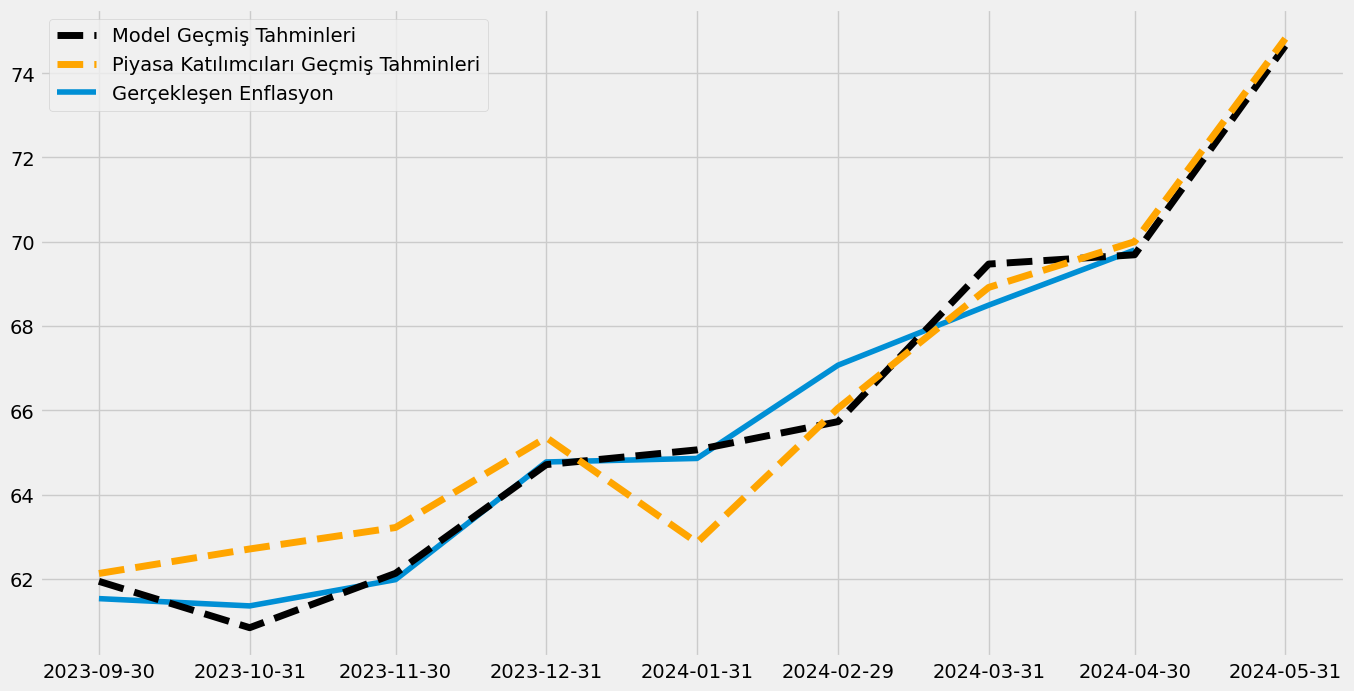

In [572]:
plt.figure(figsize=(15,8))
plt.plot(geçmiş["Tahmin"],'--',label="Model Geçmiş Tahminleri",color="black",linewidth=5,zorder=3)
plt.plot(caritüfe["Enflasyon Tahmin"],'--',label="Piyasa Katılımcıları Geçmiş Tahminleri",color="orange",linewidth=5,zorder=3)
plt.plot((enf.pct_change(12)*100).loc["2023-09-30":"2024-05-30"],label="Gerçekleşen Enflasyon")
plt.xticks(geçmiş.index)
plt.legend()

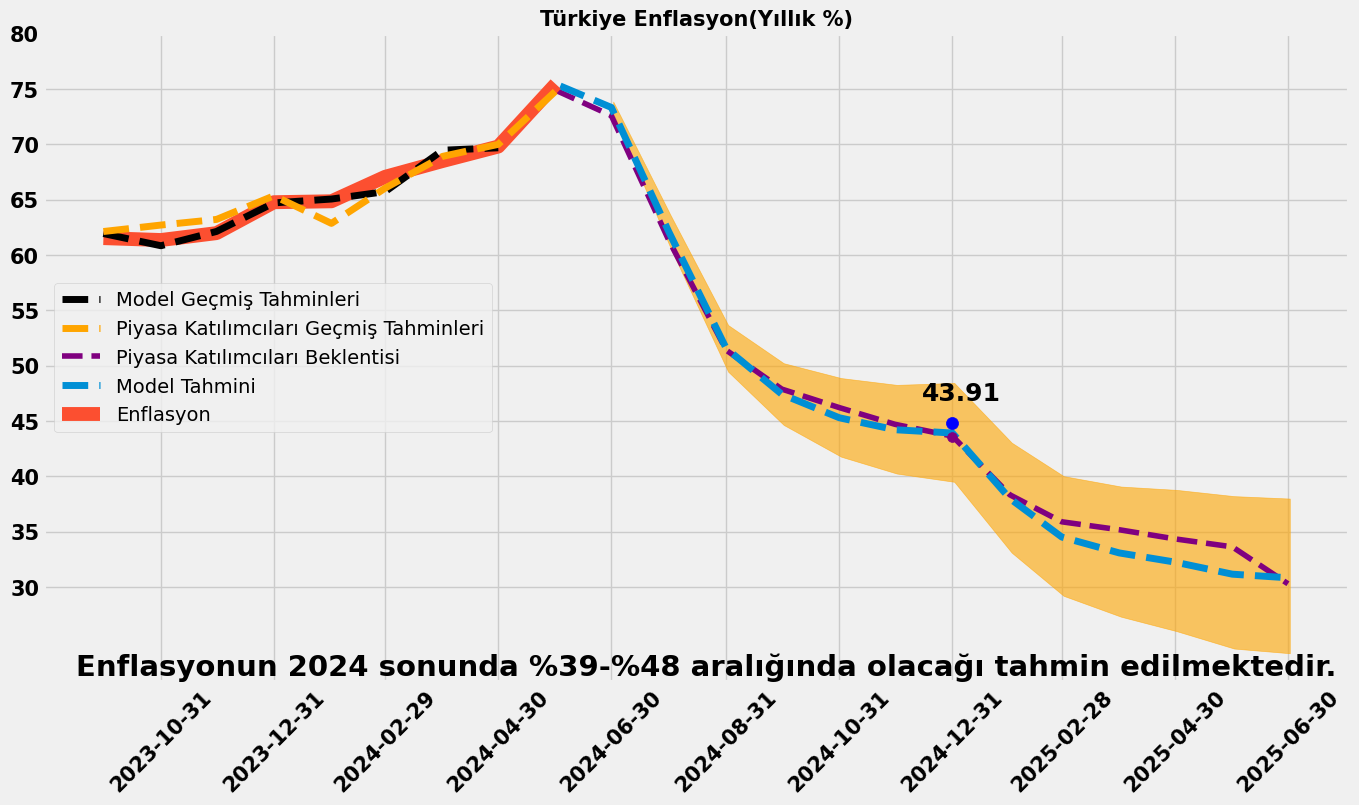

In [573]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["Beklenti"].values,color="purple",zorder=3,s=50)
geçmiş=pd.DataFrame({"Tahmin":[61.94,60.84,62.13,64.71,65.06,65.73,69.47,69.69]})
geçmiş=geçmiş.set_index(pd.date_range(start="2023-09-30",end="2024-04-30",freq="M"))
plt.plot(geçmiş["Tahmin"],'--',label="Model Geçmiş Tahminleri",color="black",linewidth=5,zorder=3)
plt.plot(caritüfe["Enflasyon Tahmin"],'--',label="Piyasa Katılımcıları Geçmiş Tahminleri",color="orange",linewidth=5,zorder=3)
plt.plot((piyasaenf.pct_change(12)*100).tail(14),"--",color="purple",label="Piyasa Katılımcıları Beklentisi")
plt.scatter(x=yıllıktahmin.index[30],y=yıllıktahmin.iloc[30,0],color='blue',zorder=4,s=75)
plt.plot(yıllıktahmin["Ensemble"].iloc[21:-1],'--',label="Model Tahmini",linewidth=5)
plt.plot(yıllıktahmin["Ensemble"].iloc[15:24],label="Enflasyon",linewidth=10)
plt.fill_between(yıllıktahmin.iloc[24:].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[24:].shift(1), yıllıktahmin["Minimum"].iloc[24:].shift(1), alpha=0.6, color='orange')
annotation_date = mdates.datestr2num('2025-07')
plt.text(mdates.datestr2num('2025-01'), float(sonu12024)+3, sonu12024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 22, f"Enflasyonun 2024 sonunda %{min1}-%{max1} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='right',fontweight='bold')
plt.xticks(yıllıktahmin.index[16::2],rotation=45,fontsize=15,fontweight="bold")
plt.yticks(np.arange(30,85,5),fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=6)
plt.savefig('forecast.png')
plt.savefig("./forecasts/"+date.today().strftime("%d-%m-%Y")+'.png')
plt.show()


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '2023-09'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-11'),
  Text(3, 0, '2023-12'),
  Text(4, 0, '2024-01'),
  Text(5, 0, '2024-02'),
  Text(6, 0, '2024-03'),
  Text(7, 0, '2024-04'),
  Text(8, 0, '2024-05')])

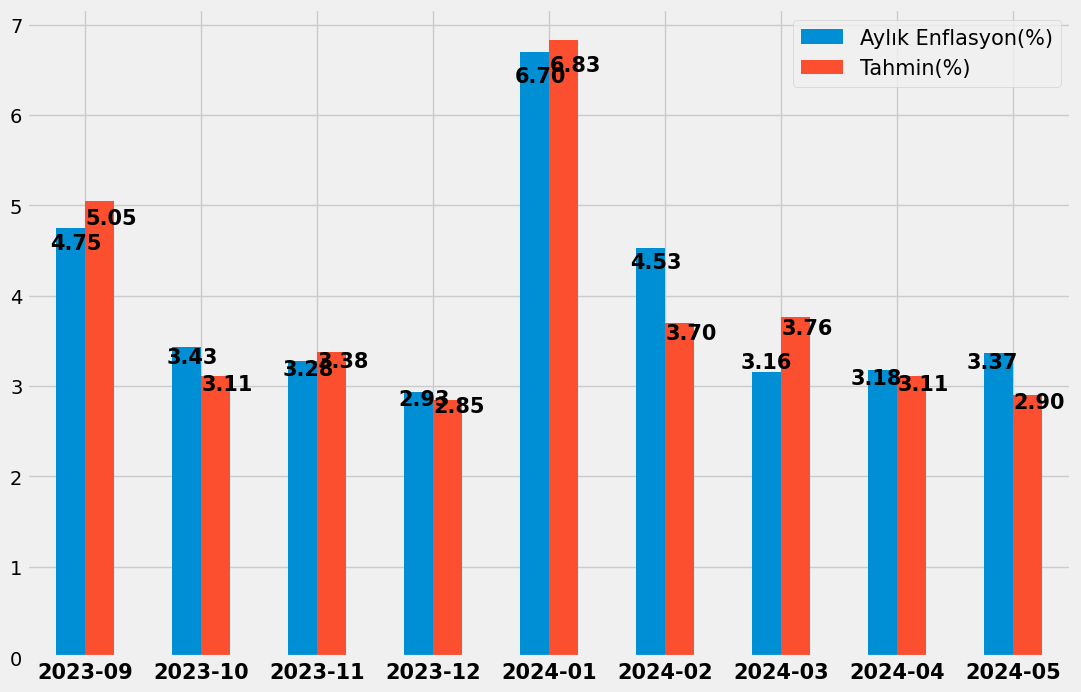

In [574]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28,2.93,6.70,4.53,3.16,3.18,3.37],"Tahmin(%)":[5.05,3.11,3.38,2.85,6.83,3.70,3.76,3.11,2.90]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=9,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar",figsize=(12,8))
plt.annotate("4.75",xy=(-0.3,gecmis.iloc[0,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("5.05",xy=(0,gecmis.iloc[0,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.43",xy=(0.7,gecmis.iloc[1,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(1,gecmis.iloc[1,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.28",xy=(1.7,gecmis.iloc[2,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.38",xy=(2,gecmis.iloc[2,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.93",xy=(2.7,gecmis.iloc[3,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.85",xy=(3,gecmis.iloc[3,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.70",xy=(3.7,gecmis.iloc[4,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.83",xy=(4,gecmis.iloc[4,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("4.53",xy=(4.7,gecmis.iloc[5,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.70",xy=(5,gecmis.iloc[5,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.16",xy=(5.65,gecmis.iloc[6,1]*0.85),fontweight="bold",fontsize=15)
plt.annotate("3.76",xy=(6,gecmis.iloc[6,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.18",xy=(6.6,gecmis.iloc[7,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(7,gecmis.iloc[7,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.37",xy=(7.6,gecmis.iloc[8,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.90",xy=(8,gecmis.iloc[8,1]*0.95),fontweight="bold",fontsize=15)


plt.legend(fontsize=15)
plt.xticks(rotation=0,fontweight="bold",fontsize=15,color="black")

In [575]:
usd

,USD/TL
2006-01-02,1.3483
2006-01-03,1.3506
2006-01-04,1.3484
2006-01-05,1.3381
2006-01-06,1.3362
...,...
2024-06-20,32.5164
2024-06-21,32.6298
2024-06-24,32.8400
2024-06-25,32.8669


Text(12.75, 2.153688378587728, '2.26')

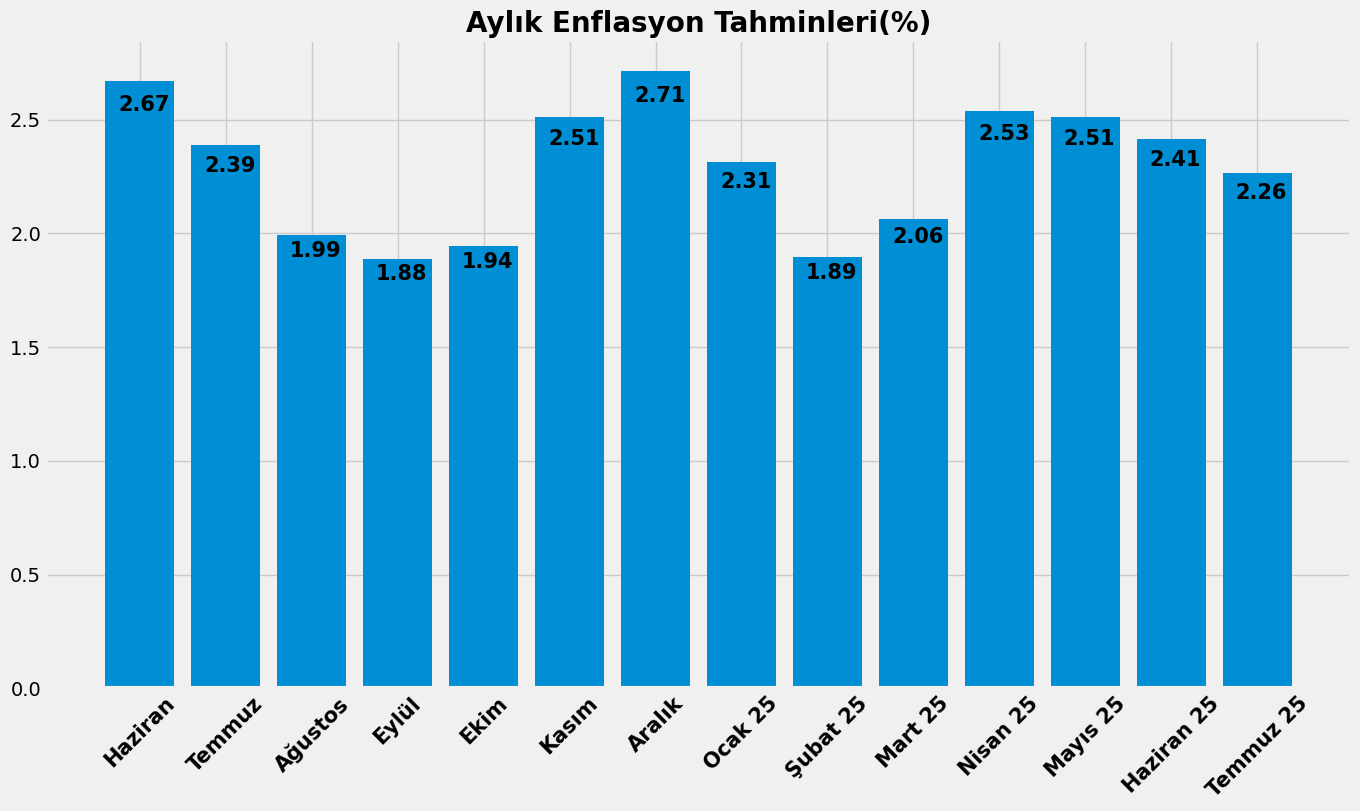

In [576]:
plt.figure(figsize=(15,8))
plt.bar(x=["Haziran","Temmuz","Ağustos","Eylül","Ekim","Kasım","Aralık","Ocak 25","Şubat 25","Mart 25","Nisan 25","Mayıs 25","Haziran 25","Temmuz 25"],height=aylıktahmin.iloc[:,-3])
plt.xticks(rotation=45,fontweight="bold",color="black",fontsize=15)
plt.title("Aylık Enflasyon Tahminleri(%)",fontweight="bold",fontsize=20)
plt.annotate(str(aylıktahmin.iloc[0,-3])[:4],xy=(-0.25,aylıktahmin.iloc[0,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[1,-3])[:4],xy=(0.75,aylıktahmin.iloc[1,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[2,-3])[:4],xy=(1.75,aylıktahmin.iloc[2,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[3,-3])[:4],xy=(2.75,aylıktahmin.iloc[3,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[4,-3])[:4],xy=(3.75,aylıktahmin.iloc[4,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[5,-3])[:4],xy=(4.75,aylıktahmin.iloc[5,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[6,-3])[:4],xy=(5.75,aylıktahmin.iloc[6,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[7,-3])[:4],xy=(6.75,aylıktahmin.iloc[7,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[8,-3])[:4],xy=(7.75,aylıktahmin.iloc[8,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[9,-3])[:4],xy=(8.75,aylıktahmin.iloc[9,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[10,-3])[:4],xy=(9.75,aylıktahmin.iloc[10,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[11,-3])[:4],xy=(10.75,aylıktahmin.iloc[11,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[12,-3])[:4],xy=(11.75,aylıktahmin.iloc[12,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[13,-3])[:4],xy=(12.75,aylıktahmin.iloc[13,-3]*0.95),fontweight="bold",fontsize=15)


